# **Домашнее задание №1 (base)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;

**Максимальная оценка за дз**
> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$


**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.**

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

### P.S Форматирование текста для красоты и быстроты делалось с помощью yandex gpt, не сами выводы. Выводы сделаны мной. Также в фукнциях он мне помогал, чтобы ускорить стандартизацию к одному виду.

In [3]:
%%capture
!pip3 install ydata-profiling

In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random
import seaborn as sns
import warnings
import pickle
import os
import re

from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from IPython.display import display, Markdown
from statsmodels.nonparametric.smoothers_lowess import lowess
from pathlib import Path
from typing import Any
from numpy import floating

warnings.filterwarnings('ignore')

random.seed(42)
np.random.seed(42)

In [5]:
def plot_box_comparison(
        df_train: pd.DataFrame,
        df_test: pd.DataFrame,
        x_col: str,
        y_col: str,
        plot_title: str
):
    """
    Строит два boxplot-графика (Train и Test) рядом с общей осью Y.

    Аргументы:
        df_train (pd.DataFrame): Обучающий набор данных.
        df_test (pd.DataFrame): Тестовый набор данных.
        x_col (str): Категориальный столбец для оси X.
        y_col (str): Числовой столбец для оси Y.
        plot_title (str): Текст, который добавляется в заголовок графика.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    sns.boxplot(data=df_train, x=x_col, y=y_col, ax=axes[0], palette="Blues")
    axes[0].set_title(f"Train: {plot_title} {x_col}", fontsize=14)
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].grid(axis="y", linestyle="--", alpha=0.5)

    sns.boxplot(data=df_test, x=x_col, y=y_col, ax=axes[1], palette="Oranges")
    axes[1].set_title(f"Test: {plot_title} {x_col}", fontsize=14)
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


def plot_scatter_comparison(
        df_train: pd.DataFrame,
        df_test: pd.DataFrame,
        x_col: str,
        y_col: str,
        plot_title: str = ""
):
    """
    Строит два scatterplot-графика (Train и Test) рядом.

    Аргументы:
        df_train (pd.DataFrame): Обучающий набор.
        df_test (pd.DataFrame): Тестовый набор.
        x_col (str): Столбец по оси X.
        y_col (str): Столбец по оси Y.
        plot_title (str): Префикс к заголовку графика.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    sns.scatterplot(
        data=df_train, x=x_col, y=y_col, ax=axes[0],
        color="blue", alpha=0.6
    )
    axes[0].set_title(f"Train: {plot_title} {x_col}", fontsize=14)
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].grid(True, linestyle="--", alpha=0.5)

    sns.scatterplot(
        data=df_test, x=x_col, y=y_col, ax=axes[1],
        color="orange", alpha=0.6
    )
    axes[1].set_title(f"Test: {plot_title} {x_col}", fontsize=14)
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


def plot_train_test_pair_plot(
        df_train: pd.DataFrame,
        df_test: pd.DataFrame,
        columns: list[str]
):
    """
    Строит PairPlot для указанных признаков, сравнивая распределения Train и Test.

    Аргументы:
        df_train (pd.DataFrame): Обучающий набор.
        df_test  (pd.DataFrame): Тестовый набор.
        columns  (list[str]): Список числовых признаков для визуализации.
    """

    train_tmp = df_train[columns].copy()
    test_tmp = df_test[columns].copy()

    train_tmp["Dataset"] = "Train"
    test_tmp["Dataset"] = "Test"

    df_combined = pd.concat([train_tmp, test_tmp], ignore_index=True)

    sns.set_theme(style="whitegrid", context="notebook", font_scale=1.0)

    figure = sns.pairplot(
        df_combined,
        vars=columns,
        hue="Dataset",
        palette={"Train": "blue", "Test": "orange"},
        diag_kind="hist",
        corner=True,
        height=2.5,
        plot_kws={"alpha": 0.3, "s": 15},
    )

    figure.figure.suptitle(
        f"Сравнение признаков Train vs Test",
        y=1.02,
        fontsize=15
    )
    plt.show()


def plot_feature_target_relationships_overlay(
        df_train: pd.DataFrame,
        df_test: pd.DataFrame,
        features: list[str],
        target: str = "log_selling_price",
        smooth_frac: float = 0.3
):
    """
    Строит графики зависимости признаков от таргета,
    накладывая Train и Test друг на друга.

    Синие точки — Train
    Оранжевые точки — Test
    Красная линия — тренд Train
    Зеленая линия — тренд Test

    Аргументы:
        df_train (pd.DataFrame): Обучающий набор.
        df_test  (pd.DataFrame): Тестовый набор.
        features: list[str]: Список признаков для визуализации.
        target: str: Целевая переменная
    """

    n_cols = 3
    n_rows = int(np.ceil(len(features) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, n_rows * 6))
    axes = axes.flatten()

    for idx, feature in enumerate(features):

        ax = axes[idx]

        ax.scatter(df_train[feature], df_train[target],
                   color="blue", alpha=0.25, s=12, label="Train")

        ax.scatter(df_test[feature], df_test[target],
                   color="orange", alpha=0.25, s=12, label="Test")

        try:
            sm_train = lowess(df_train[target], df_train[feature],
                              frac=smooth_frac, return_sorted=True)
            ax.plot(sm_train[:, 0], sm_train[:, 1], color="red", linewidth=2, label="Train trend")
        except Exception:
            pass

        try:
            sm_test = lowess(df_test[target], df_test[feature],
                             frac=smooth_frac, return_sorted=True)
            ax.plot(sm_test[:, 0], sm_test[:, 1], color="green", linewidth=2, label="Test trend")
        except Exception:
            pass

        ax.set_title(f"{feature} и {target}")
        ax.set_xlabel(feature)
        ax.set_ylabel(target)
        ax.grid(alpha=0.3)

        if idx == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()


def plot_target_distribution(
        df_train: pd.DataFrame,
        df_test: pd.DataFrame,
        target_col: str
):
    """
    Сравнивает распределение целевой переменной в Train и Test
    в оригинальном масштабе и в логарифмическом.

    Аргументы:
        df_train (pd.DataFrame): Обучающий набор.
        df_test (pd.DataFrame): Тестовый набор.
        target_col (str): Название таргета.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.kdeplot(
        df_train[target_col], fill=True, ax=ax[0],
        label="Train", color="blue", alpha=0.3
    )
    sns.kdeplot(
        df_test[target_col], fill=True, ax=ax[0],
        label="Test", color="orange", alpha=0.3
    )
    ax[0].set_title("Исходное распределение")
    ax[0].legend()
    ax[0].grid(linestyle="--", alpha=0.5)

    sns.kdeplot(
        np.log1p(df_train[target_col]), fill=True, ax=ax[1],
        label="Train", color="blue", alpha=0.3
    )
    sns.kdeplot(
        np.log1p(df_test[target_col]), fill=True, ax=ax[1],
        label="Test", color="orange", alpha=0.3
    )
    ax[1].set_title("Логарифмированное распределение")
    ax[1].legend()
    ax[1].grid(linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


def evaluate_regression(
        model,
        X_train,
        y_train_log,
        X_val,
        y_val_log,
        model_name: str,
        scaler=None
):
    """
    Обучает модель на логарифмированном таргете и оценивает качество в оригинальном масштабе.

    Аргументы:
        model: модель (LinearRegression, Ridge, Lasso, CatBoost и т.д.)
        X_train: признаки обучающей выборки
        y_train_log: log(tarгета)
        X_val: признаки валидационной выборки
        y_val_log: log(tаргета)
        model_name: имя модели
        scaler: если передан, применяет transform() к X_val внутри функции
    """

    if scaler is not None:
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    else:
        X_train_scaled = X_train
        X_val_scaled = X_val

    model.fit(X_train_scaled, y_train_log)

    y_pred_log = model.predict(X_val_scaled)

    y_val_real = np.expm1(y_val_log)
    y_pred_real = np.expm1(y_pred_log)

    rmse = np.sqrt(MSE(y_val_real, y_pred_real))
    mae = np.mean(np.abs(y_val_real - y_pred_real))
    r2 = r2_score(y_val_real, y_pred_real)

    display(Markdown(f"### {model_name}"))
    display(Markdown(f"- **RMSE:** `{rmse:,.5f}`"))
    display(Markdown(f"- **MAE:** `{mae:,.5f}`"))
    display(Markdown(f"- **R²:** `{r2:.5f}`"))
    display(Markdown("---"))

    return {
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "FittedModel": model
    }


def check_duplicates(df: pd.DataFrame, df_name: str):
    """
    Ищет и выводит полные или частичные дубликаты строк.

    Аргументы:
        df (pd.DataFrame): Исследуемый датафрейм.
        df_name (str): Название (Train/Test).
    """
    duplicates = df[df.duplicated(keep=False)]
    num_duplicates = df.duplicated().sum()

    display(Markdown(f"#### Анализ дубликатов в **`{df_name}`**"))

    if duplicates.empty:
        display(Markdown("**Полных дубликатов не найдено.**"))
        return

    display(Markdown(f"#### Найдено **{num_duplicates}** дублирующихся записей."))
    display(Markdown(f"#### Размер до удаления: **`{df.shape}`**"))

    display(duplicates.sort_values(by=df.columns.tolist()).head(10))


def duplicated_rows_number(df: pd.DataFrame, df_name: str):
    """
    Считает количество объектов с одинаковым признаковым описанием
    (без целевой переменной).

    Аргументы:
        df (pd.DataFrame): Исследуемый датафрейм.
        df_name (str): Название (Train/Test).
    """
    df_drop_target = df.drop("selling_price", axis=1)
    num_duplicates = df_drop_target.duplicated().sum()

    display(Markdown(
        f"### Количество объектов в **{df_name}**"
        f"с одинаковым описанием признаков: **`{num_duplicates}`**"
    ))


def preprocess_num_features(df: pd.DataFrame, cols_to_clean: list[str]) -> pd.DataFrame:
    """
    Предобрабатывает числовые признаки + извлекает torque, rpm, мощность.

    Создаёт фичи:
        - torque_nm — крутящий момент в Н·м
        - torque_max_rpm — обороты максимального момента
        - engine_power_estimated — мощность, рассчитанная через формулу (Nm * RPM) / 9549
        - car_age — возраст авто

    Аргументы:
        df : DataFrame — входные данные
        cols_to_clean : list[str] — столбцы, где нужно извлекать первое число
    """

    for col in cols_to_clean:
        if col in df.columns:
            extracted = df[col].astype(str).str.extract(r"(\d+(?:\.\d+)?)")[0]
            df[col] = pd.to_numeric(extracted, errors="coerce")

    if "torque" in df.columns:

        def parse_torque_nm(value: str):
            """
            Парсинг крутящего момента авто
            """
            if not isinstance(value, str):
                return np.nan

            match = re.search(r"(\d+(?:\.\d+)?)\s*(nm|kgm)?", value.lower())
            if not match:
                return np.nan

            num = float(match.group(1))
            unit = match.group(2)

            if unit is None or unit == "nm":
                return num
            elif unit == "kgm":
                return num * 9.80665
            else:
                return np.nan

        df["torque_nm"] = df["torque"].apply(parse_torque_nm)

        rpm = (
            df["torque"]
            .astype(str)
            .str.replace(",", "")
            .str.extract(r"[at@].*?(\d+(?:\.\d+)*)")[0]
        )

        df["torque_max_rpm"] = pd.to_numeric(rpm, errors="coerce")

        df["engine_power_estimated"] = (
                df["torque_nm"] * df["torque_max_rpm"] / 9549
        )
        df = df.drop(columns=["torque"], errors="ignore")

    if "year" in df.columns:
        current_year = df["year"].max()
        df["car_age"] = current_year - df["year"]

    return df


def show_diff_stats(
        df_before: pd.DataFrame,
        df_after: pd.DataFrame,
        df_name: str,
        df_dtype: str
):
    """
    Сравнивает статистики признаков до и после заполнения пропусков в Train и Test.

    Аргументы:
        df_before (pd.DataFrame): Данные до заполнения пропусков.
        df_after (pd.DataFrame): Данные после заполнения пропусков.
        df_name (str): Название набора данных.
        df_dtype (str): Тип признаков:
            - 'numeric' — числовые
            - 'categorical' — категориальные
    """
    if df_dtype == "numeric":
        metrics = ["count", "mean", "50%", "std", "min", "max"]
        include_type = [np.number]
        title = f"Изменения в числовых признаках для {df_name}"

    elif df_dtype == "categorical":
        metrics = ["count", "unique", "top", "freq"]
        include_type = [object, "category"]
        title = f"Изменения в категориальных признаках для {df_name}"

    else:
        raise ValueError("Тип должен быть 'numeric' или 'categorical'.")

    desc_before = df_before.describe(include=include_type).T[metrics]
    desc_after = df_after.describe(include=include_type).T[metrics]

    comparison = pd.concat([desc_before, desc_after], axis=1,
                           keys=["До", "После"])
    comparison = comparison.swaplevel(axis=1).sort_index(axis=1)

    display(Markdown(f"#### {title}"))

    if df_dtype == "numeric":
        display(
            comparison.style.format("{:.2f}").highlight_null(color="red")
        )
    else:
        display(comparison)


def compare_corr_heatmap(
        df_train: pd.DataFrame,
        df_test: pd.DataFrame,
        plot_title: str = ""
):
    """
    Строит две матрицы корреляций для Train и Test
    с единой цветовой шкалой.

    Аргументы:
        df_train (pd.DataFrame): Обучающий набор.
        df_test (pd.DataFrame): Тестовый набор.
        plot_title (str): Заголовок всей визуализации.
    """
    corr_train = df_train.corr(numeric_only=True)
    corr_test = df_test.corr(numeric_only=True)

    vmin = min(corr_train.min().min(), corr_test.min().min())
    vmax = max(corr_train.max().max(), corr_test.max().max())

    mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
    mask_test = np.triu(np.ones_like(corr_test, dtype=bool))

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    sns.heatmap(
        corr_train,
        mask=mask_train,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        linewidths=.5,
        ax=axes[0],
        cbar=False
    )
    axes[0].set_title("Обучающая выборка Train")

    sns.heatmap(
        corr_test,
        mask=mask_test,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        linewidths=.5,
        ax=axes[1],
        cbar=True
    )
    axes[1].set_title("Тестовая выборка Test")

    fig.suptitle(plot_title, fontsize=18)
    plt.tight_layout()
    plt.show()


def extract_brand(name_str: str) -> str:
    """
    Извлекает марку автомобиля (первое слово из названия).

    Аргументы:
        name_str (str): Полное название автомобиля.

    Возвращает:
        str: Марка авто.
    """
    return name_str.split(" ")[0]


def business_metric(y_true: np.array, y_pred: np.array) -> floating[Any]:
    """
    Рассчитывает долю предсказаний, отклонение которых от реальных значений
    не превышает 10%.

    Аргументы:
        y_true (np.array): Реальные значения.
        y_pred (np.array): Предсказанные значения.

    Возвращает:
        float: Процент корректных предсказаний.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    abs_diff = np.abs(y_true - y_pred)
    tolerance = 0.10 * y_true
    accurate = abs_diff <= tolerance

    return np.mean(accurate) * 100


def show_head_tail_data(df: pd.DataFrame, df_name: str):
    """
    Показывает первые 5 и последние 5 строк датафрейма.

    Аргументы:
        df (pd.DataFrame): Датафрейм.
        df_name (str): Название набора для вывода.
    """
    display(Markdown(f"#### Первые 5 строк набора {df_name}:"))
    display(df.head())

    display(Markdown(f"#### Последние 5 строк набора {df_name}:"))
    display(df.tail())


def box_plot_for_categories(df_train: pd.DataFrame, df_test: pd.DataFrame, x_col: str, y_col: str,
                            plot_title: str = ""):
    """
    Строит сравнительные boxplot'ы специально для признака 'seats' или других дискретных.

    Аргументы:
        df_train (pd.DataFrame): Обучающий набор.
        df_test (pd.DataFrame): Тестовый набор.
        x_col: str: По какому столбцу рисуется ось X.
        y_col: str: По какому столбцу рисуется ось Y.
        plot_title (str): Заголовок всей визуализации.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    sns.boxplot(data=df_train, x=x_col, y=y_col, ax=axes[0], palette='Blues')
    axes[0].set_title(f"Train: {plot_title} {x_col}", fontsize=14)
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)

    sns.boxplot(data=df_test, x=x_col, y=y_col, ax=axes[1], palette='Oranges')
    axes[1].set_title(f"Test: {plot_title} {x_col}", fontsize=14)
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


In [6]:
NUM_COLS = ["km_driven", "mileage", "engine", "max_power", "year", "seats", "torque_nm", "torque_max_rpm",
            "engine_power_estimated"]
CAT_COLS = ["fuel", "seller_type", "transmission", "owner", "brand"]

Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

> ### Мы фиксируем seed (сид), чтобы получить воспроизводимость экспериментов, т.е, чтобы я или преподаватель смогли запустить ячейки и получить такие же ответы.



# **Часть 1 | EDA и визуализация**

Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (2.5 балла)
- Визуализации признаков и их анализ (1 балл)

Всего можно набрать 3.5 основных балла и 0.65 бонусных. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (2.5 балла)**

In [7]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

In [8]:
display(Markdown(f"* #### Train `data` shape: **{df_train.shape}**"))
display(Markdown(f"* #### Test `data` shape: **{df_test.shape}**"))

* #### Train `data` shape: **(6999, 13)**

* #### Test `data` shape: **(1000, 13)**

### **Задание 1 (0.5 балла)**

Вы уже встречались с pandas в первой половине семестра. Теперь будем постоянно (кроме некоторых случаев) использовать его для анализа данных и наслаивать навыки. Выполните операции, направленные на практику основных действий с `pandas`:

- [✅] Отобразить 30 случайных строк тренировочного датасета.
- [✅] Отобразить первые 5 и последние 5 объектов тестового датасета
- [✅] Посмотреть, есть ли в датасете пропуски. Запишите/выведите названия колонок, для которых есть пропущенные значения
- [✅] Посмотреть, есть ли в данных явные дубликаты


**0.2 балла**
Ответьте на вопросы:
- [✅] Выводы о чем можно сделать, используя случайные/верхние/нижние строки? А о чем нельзя?
- [✅] Достаточно ли метода duplicated для анализа дубликатов? Почему?

**0.15 балла**
- [✅] Постройте дашборд, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)

In [9]:
display(Markdown(f"### Случайные 30 строк `Train` набора:"))
display(df_train.sample(30, random_state=42))

### Случайные 30 строк `Train` набора:

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6565,Renault KWID Climber 1.0 MT BSIV,2019,300000,35000,Petrol,Individual,Manual,First Owner,23.01 kmpl,999 CC,67 bhp,91Nm@ 4250rpm,5.0
2943,Maruti Wagon R LXI,2013,225000,58343,Petrol,Trustmark Dealer,Manual,First Owner,21.79 kmpl,998 CC,67.05 bhp,90Nm@ 3500rpm,5.0
2024,Hyundai i20 Asta 1.2,2013,360000,30000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
263,Hyundai i20 1.2 Asta,2010,300000,70000,Petrol,Individual,Manual,First Owner,17.0 kmpl,1197 CC,80 bhp,"11.4 kgm at 4,000 rpm",5.0
4586,Skoda Octavia L and K 1.9 TDI MT,2005,250000,120000,Diesel,Individual,Manual,Third Owner,16.4 kmpl,1896 CC,90 bhp,"21.4@ 1,900(kgm@ rpm)",5.0
4479,Maruti Ciaz ZXi,2016,700000,20000,Petrol,Individual,Manual,First Owner,20.73 kmpl,1373 CC,91.1 bhp,130Nm@ 4000rpm,5.0
4881,Hyundai Grand i10 1.2 Kappa Magna BSIV,2017,445000,27000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
3583,Ford Ecosport 1.5 DV5 MT Trend,2016,515000,68609,Diesel,Dealer,Manual,First Owner,22.7 kmpl,1498 CC,89.84 bhp,204Nm@ 2000-2750rpm,5.0
6361,Hyundai Verna 1.4 VTVT,2014,500000,33400,Petrol,Individual,Manual,First Owner,17.43 kmpl,1396 CC,105.5 bhp,135.3Nm@ 5000rpm,5.0
4108,Hyundai i20 Era 1.2,2015,490000,45900,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0


In [10]:
display(Markdown(f"### Случайные 30 строк `Test` набора:"))
display(df_test.sample(30, random_state=42))

### Случайные 30 строк `Test` набора:

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
521,Tata Tigor 1.2 Revotron XT,2018,450000,35000,Petrol,Individual,Manual,First Owner,20.3 kmpl,1199 CC,84 bhp,114Nm@ 3500rpm,5.0
737,Mahindra NuvoSport N8 AMT,2016,650000,50000,Diesel,Individual,Automatic,First Owner,17.45 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0
740,Toyota Innova 2.5 GX 7 STR,2012,520000,162000,Diesel,Individual,Manual,Fourth & Above Owner,12.8 kmpl,2494 CC,102 bhp,20.4@ 1400-3400(kgm@ rpm),7.0
660,Hyundai Sonata 2.0L CRDi MT,2009,330000,180000,Diesel,Individual,Manual,First Owner,13.6 kmpl,1991 CC,142 bhp,"33@ 2,000-2,680(kgm@ rpm)",5.0
411,Hyundai i20 1.4 CRDi Era,2010,350000,90000,Diesel,Individual,Manual,Second Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
678,Maruti Vitara Brezza ZDi Plus,2019,900000,40000,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0
626,Maruti 800 AC,2006,50000,40000,Petrol,Individual,Manual,Third Owner,16.1 kmpl,796 CC,37 bhp,59Nm@ 2500rpm,4.0
513,Hyundai Grand i10 Magna,2016,400000,80000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0
859,Maruti Wagon R VXI BS IV with ABS,2010,215000,120600,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0
136,Mahindra Verito 1.5 D2 BSIV,2012,140000,120000,Diesel,Individual,Manual,Second Owner,21.03 kmpl,1461 CC,65 bhp,160Nm@ 2000rpm,5.0


> ### Проведен первичный визуальный аудит 30 случайных строк из `Train` и `Test`. Форматы признаков, категории и значения выглядят согласованно, артефактов и явных ошибок не наблюдается. Это говорит о том, что оба набора данных имеют общую структуру и предварительно выглядят согласованными, что важно для стабильного обучения модели.

In [11]:
show_head_tail_data(df_train, "Train")

#### Первые 5 строк набора Train:

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


#### Последние 5 строк набора Train:

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6994,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
6995,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
6996,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0
6998,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


In [12]:
show_head_tail_data(df_test, "Test")

#### Первые 5 строк набора Test:

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


#### Последние 5 строк набора Test:

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81 kmpl,1086 CC,68.05 bhp,99.04Nm@ 4500rpm,5.0
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,81.83 bhp,114.7Nm@ 4000rpm,5.0
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36 kmpl,1197 CC,78.9 bhp,111.8Nm@ 4000rpm,5.0
999,Honda City i DTec SV,2016,700000,110000,Diesel,Individual,Manual,First Owner,26.0 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0


### Выводы о чем можно сделать, используя случайные/верхние/нижние строки? А о чем нельзя?
> ### Просмотр первых, последних и случайных строк Train и Test позволяет:
  - убедиться в корректной загрузке данных.
  - предварительно оценить типы признаков и выявить текстовые поля, содержащие единицы измерения.
  - обнаружить возможные артефакты: смешанные форматы, пустые строки, неверные категории.
  - заметить потенциальные выбросы, если они попадают в выборку.

> ### Но оценить распределения признаков, баланс категорий, наличие выбросов в масштабе всего датасета, корреляции и другие статистические свойства почти невозможно на данном этапе. Нужно делать полный EDA.


In [13]:
missing_df = pd.DataFrame({
    "df_train_missings": df_train.isna().sum(),
    "df_test_missings": df_test.isna().sum()
})

missing_df = missing_df[missing_df.sum(axis=1) > 0]

display(Markdown(f"### Кол-во пропущенных строк наборов `Train` и `Test`:"))
display(missing_df)

### Кол-во пропущенных строк наборов `Train` и `Test`:

,df_train_missings,df_test_missings
mileage,202,19
engine,202,19
max_power,196,19
torque,203,19
seats,202,19


> ### В наборах `train` и `test` есть пропущенные значения в числовых столбцах и их довольно много. Перед заполнением пропусков эти признаки необходимо очистить от текстовых единиц измерения и преобразовать к числовому типу. Нужно будет сделать заполнения пропусков скорее всего медианой.

In [14]:
display(Markdown(
    f"* #### Пропущенные столбцы: **{", ".join(missing_df.index.to_list())}**, их кол-во: **{len(missing_df.index.to_list())}**"))

* #### Пропущенные столбцы: **mileage, engine, max_power, torque, seats**, их кол-во: **5**

In [15]:
display(Markdown(f"### Дубликаты строк набора `Train`:"))
display(df_train[df_train.duplicated()])

### Дубликаты строк набора `Train`:

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
254,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0
258,Maruti Swift VXI,2012,330000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,85.8 bhp,114Nm@ 4000rpm,5.0
324,Jaguar XE 2016-2019 2.0L Diesel Prestige,2017,2625000,9000,Diesel,Dealer,Automatic,First Owner,13.6 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0
325,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56 bhp,202Nm@ 3600-5200rpm,5.0
326,Jaguar XF 2.0 Diesel Portfolio,2017,3200000,45000,Diesel,Dealer,Automatic,First Owner,19.33 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6880,Renault Captur 1.5 Diesel RXT,2018,1265000,12000,Diesel,Individual,Manual,First Owner,20.37 kmpl,1461 CC,108.45 bhp,240Nm@ 1750rpm,5.0
6881,Maruti Ciaz Alpha Diesel,2019,1025000,32000,Diesel,Individual,Manual,First Owner,28.09 kmpl,1248 CC,88.50 bhp,200Nm@ 1750rpm,5.0
6989,Maruti Swift Dzire VDI,2015,625000,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


In [16]:
display(Markdown(f"### Дубликаты строк набора `Test`:"))
display(df_test[df_test.duplicated()])

### Дубликаты строк набора `Test`:

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
200,Maruti Swift AMT VVT VXI,2019,650000,5621,Petrol,Trustmark Dealer,Automatic,First Owner,22.0 kmpl,1197 CC,81.80 bhp,113Nm@ 4200rpm,5.0
235,Hyundai Grand i10 1.2 CRDi Sportz,2017,450000,56290,Diesel,Dealer,Manual,First Owner,24.0 kmpl,1186 CC,73.97 bhp,190.24nm@ 1750-2250rpm,5.0
238,Toyota Camry 2.5 Hybrid,2016,2000000,68089,Petrol,Trustmark Dealer,Automatic,First Owner,19.16 kmpl,2494 CC,157.7 bhp,213Nm@ 4500rpm,5.0
253,Tata Safari Storme EX,2015,503000,110000,Diesel,Individual,Manual,First Owner,14.1 kmpl,2179 CC,147.94 bhp,320Nm@ 1500-3000rpm,7.0
269,Jaguar XF 2.0 Diesel Portfolio,2017,3200000,45000,Diesel,Dealer,Automatic,First Owner,19.33 kmpl,1999 CC,177 bhp,430Nm@ 1750-2500rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,Mercedes-Benz S-Class S 350 CDI,2017,6000000,37000,Diesel,Dealer,Automatic,First Owner,13.5 kmpl,2987 CC,254.79 bhp,620Nm@ 1600-2400rpm,5.0
936,BMW X4 M Sport X xDrive20d,2019,5500000,8500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
949,Toyota Camry 2.5 Hybrid,2016,2000000,68089,Petrol,Trustmark Dealer,Automatic,First Owner,19.16 kmpl,2494 CC,157.7 bhp,213Nm@ 4500rpm,5.0
971,Maruti Ertiga SHVS ZDI Plus,2017,750000,50000,Diesel,Individual,Manual,First Owner,24.52 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,7.0


### Достаточно ли метода `duplicated()` для анализа дубликатов? Почему?

> Нет, так как этот метод ищет полные дублирующиеся строки по всем признакам, т.е если все признаки объектов будут одинаковыми и только один столбец отличаться - это будет считаться разными строчками методом `duplicated()`, и если я не ошибаюсь `duplicated()` не чувствителен к регистру т.е hudndai Hundai - разные или были занесены данные с разными целевыми переменными.

In [17]:
profile = ProfileReport(df_train, title='Profiling Report')
profile.to_file(Path('../../HW1/pandas_profiler/auto_price_report.html'))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:00<00:00, 266.88it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### **Задание 2 (0.5 балла)**

На прошлом шаге вы убедились, что явных дубликатов в таблице нет. Однако дубликат может быть связан с не только полным повторением информации в нескольких строках, но и частиным. Например, объект мог был внесен в базу данных с разным значением целевой переменной. В этом шаге займемся такими дублями!

**Ваши действия:**

- [✅] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.1 балла)
- [✅] Отобразите такие объекты (0.15 балла)
- [✅] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.15 балла)
- [✅]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.1 балла)


In [18]:
df_train_dropped_target = df_train.drop("selling_price", axis=1)
num_duplicates_train = df_train_dropped_target.duplicated().sum()
display(
    Markdown(f"* #### Количество объектов в df_train с одинаковым признаковым описанием: **{num_duplicates_train}**"))

* #### Количество объектов в df_train с одинаковым признаковым описанием: **1159**

In [19]:
df_test_dropped_target = df_test.drop("selling_price", axis=1)
num_duplicates_test = df_test_dropped_target.duplicated().sum()
display(Markdown(f"* #### Количество объектов в Test с одинаковым признаковым описанием: **{num_duplicates_test}**"))

* #### Количество объектов в Test с одинаковым признаковым описанием: **69**

In [20]:
check_duplicates(df_train, "Train")

#### Анализ дубликатов в **`Train`**

#### Найдено **985** дублирующихся записей.

#### Размер до удаления: **`(6999, 13)`**

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
1703,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33 bhp,380Nm@ 1750-2500rpm,5.0
6307,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33 bhp,380Nm@ 1750-2500rpm,5.0
1836,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4 bhp,580Nm@ 1400-3250rpm,5.0
6704,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4 bhp,580Nm@ 1400-3250rpm,5.0
117,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
1337,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
1595,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
2787,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
4485,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
6640,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0


In [21]:
check_duplicates(df_test, "Test")

#### Анализ дубликатов в **`Test`**

#### Найдено **62** дублирующихся записей.

#### Размер до удаления: **`(1000, 13)`**

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
61,BMW X4 M Sport X xDrive20d,2019,5400000,7500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
515,BMW X4 M Sport X xDrive20d,2019,5400000,7500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
201,BMW X4 M Sport X xDrive20d,2019,5500000,8500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
600,BMW X4 M Sport X xDrive20d,2019,5500000,8500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
777,BMW X4 M Sport X xDrive20d,2019,5500000,8500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
936,BMW X4 M Sport X xDrive20d,2019,5500000,8500,Diesel,Dealer,Automatic,First Owner,16.78 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0
77,Honda Jazz VX,2016,550000,56494,Petrol,Trustmark Dealer,Manual,First Owner,18.2 kmpl,1199 CC,88.7 bhp,110Nm@ 4800rpm,5.0
283,Honda Jazz VX,2016,550000,56494,Petrol,Trustmark Dealer,Manual,First Owner,18.2 kmpl,1199 CC,88.7 bhp,110Nm@ 4800rpm,5.0
289,Honda Jazz VX,2016,550000,56494,Petrol,Trustmark Dealer,Manual,First Owner,18.2 kmpl,1199 CC,88.7 bhp,110Nm@ 4800rpm,5.0
431,Honda Jazz VX,2016,550000,56494,Petrol,Trustmark Dealer,Manual,First Owner,18.2 kmpl,1199 CC,88.7 bhp,110Nm@ 4800rpm,5.0


In [22]:
df_train.drop_duplicates(df_train_dropped_target, keep="first", inplace=True)
display(Markdown(f"* #### Размер `Train` после удаления **`{df_train.shape}`**"))

* #### Размер `Train` после удаления **`(5840, 13)`**

In [23]:
df_test.drop_duplicates(df_test_dropped_target, keep="first", inplace=True)
display(Markdown(f"* #### Размер `Test` после удаления **`{df_test.shape}`**"))

* #### Размер `Test` после удаления **`(931, 13)`**

In [24]:
df_train.reset_index(drop=True, inplace=True)
display(
    Markdown(f"* #### Первый индекс `Train`: {df_train.index[0]} и последний индекс `Train`: **{df_train.index[-1]}**"))

* #### Первый индекс `Train`: 0 и последний индекс `Train`: **5839**

In [25]:
df_test.reset_index(drop=True, inplace=True)
display(Markdown(f"* #### Первый индекс `Test`: {df_test.index[0]} и последний индекс `Test`: **{df_test.index[-1]}**"))

* #### Первый индекс `Test`: 0 и последний индекс `Test`: **930**

In [26]:
assert df_train.shape == (5840, 13)

In [27]:
assert df_test.shape == (931, 13)

Отлично! Мы избавились от маленьких и явных проблем. Теперь перейдем к более сложным недостаткам полученной таблицы.

### **Задание 3 (0.25 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [✅] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [✅] Приведите тип данных к ``float``.
* [✅] Удалите столбец ``torque``


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.
- Стобец ``torque`` мы удаляем для простоты. В идеальном случае, его также стоило бы предобработать.

In [28]:
df_data_types = pd.DataFrame({
    "df_train_ddtype": df_train.dtypes,
    "df_test_ddtype": df_test.dtypes
})

display(Markdown(f"### Типы признаков для `Train` и `Test`:"))
display(df_data_types)

### Типы признаков для `Train` и `Test`:

,df_train_ddtype,df_test_ddtype
name,object,object
year,int64,int64
selling_price,int64,int64
km_driven,int64,int64
fuel,object,object
seller_type,object,object
transmission,object,object
owner,object,object
mileage,object,object
engine,object,object


In [29]:
df_train_transformed_ddtypes = preprocess_num_features(df_train, ["max_power", "mileage", "engine"])
df_test_transformed_ddtypes = preprocess_num_features(df_test, ["max_power", "mileage", "engine"])

In [30]:
train_dtypes = df_train_transformed_ddtypes.dtypes.rename("df_train_ddtypes")
test_dtypes = df_test_transformed_ddtypes.dtypes.rename("df_test_ddtypes")

train_nulls = df_train_transformed_ddtypes.isnull().sum().rename("df_train_nulls")
test_nulls = df_test_transformed_ddtypes.isnull().sum().rename("df_test_nulls")

df_combined_info = pd.concat([
    train_dtypes,
    test_dtypes,
    train_nulls,
    test_nulls
], axis=1)

display(df_combined_info)

,df_train_ddtypes,df_test_ddtypes,df_train_nulls,df_test_nulls
name,object,object,0,0
year,int64,int64,0,0
selling_price,int64,int64,0,0
km_driven,int64,int64,0,0
fuel,object,object,0,0
seller_type,object,object,0,0
transmission,object,object,0,0
owner,object,object,0,0
mileage,float64,float64,186,19
engine,float64,float64,186,19


Мы обнаружили пропуски. Давайте избавимся от них.

**(0.05 балла)**
- [✅] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось. Заполнение пропусков проводите для обоих наборов данных, если необходимо

**Важно!**

При заполнении пропусков и в тестовом, и тренировочном наборах данных вы определяетесь со стратегией предобработки пропущенных значений при потенциальной работе модели.

Так как в теоретическом случае вы не имеете доступа к тестовой выборке, то заполняемой значение (у нас — медиана) вы считаете про *тренировочному* набору данных и им же заполняете *тестовый*.

In [31]:
median_values = {}
for column in df_train_transformed_ddtypes[
    ["mileage", "engine", "max_power", "seats", "torque_nm", "torque_max_rpm", "engine_power_estimated"]]:
    if df_train_transformed_ddtypes[column].isnull().any():
        median_val = df_train_transformed_ddtypes[column].median()
        median_values[column] = median_val
        display(Markdown(f"* #### Медиана для столбца `{column}` из df_train: **{median_val:.2f}**"))

* #### Медиана для столбца `mileage` из df_train: **19.37**

* #### Медиана для столбца `engine` из df_train: **1248.00**

* #### Медиана для столбца `max_power` из df_train: **81.86**

* #### Медиана для столбца `seats` из df_train: **5.00**

* #### Медиана для столбца `torque_nm` из df_train: **153.00**

* #### Медиана для столбца `torque_max_rpm` из df_train: **2000.00**

* #### Медиана для столбца `engine_power_estimated` из df_train: **39.27**

In [32]:
df_train = df_train_transformed_ddtypes.copy()
for column, median_val in median_values.items():
    df_train.fillna({column: median_val}, inplace=True)

In [33]:
df_test = df_test_transformed_ddtypes.copy()
for column, median_val in median_values.items():
    df_test.fillna({column: median_val}, inplace=True)

In [34]:
missing_df = pd.DataFrame({
    "df_train_missings": df_train.isna().sum(),
    "df_test_missings": df_test.isna().sum()
})

display(Markdown(f"### Кол-во пропущенных строк наборов `Train` и `Test`:"))
display(missing_df)

### Кол-во пропущенных строк наборов `Train` и `Test`:

,df_train_missings,df_test_missings
name,0,0
year,0,0
selling_price,0,0
km_driven,0,0
fuel,0,0
seller_type,0,0
transmission,0,0
owner,0,0
mileage,0,0
engine,0,0


### **Задание 4 (0.1 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [✅] Осуществите приведение столбцов к необходимому типу.

In [35]:
df_train["engine"] = df_train["engine"].astype(int)
df_train["seats"] = df_train["seats"].astype(int)

In [36]:
df_test["engine"] = df_test["engine"].astype(int)
df_test["seats"] = df_test["seats"].astype(int)

In [37]:
df_data_types = pd.DataFrame({
    "df_train_ddtype": df_train.dtypes,
    "df_test_ddtype": df_test.dtypes
})

display(Markdown(f"### Типы признаков для `Train` и `Test`:"))
display(df_data_types)

### Типы признаков для `Train` и `Test`:

,df_train_ddtype,df_test_ddtype
name,object,object
year,int64,int64
selling_price,int64,int64
km_driven,int64,int64
fuel,object,object
seller_type,object,object
transmission,object,object
owner,object,object
mileage,float64,float64
engine,int64,int64


### **Задание 5 (0.15 балла)**

Отлично! Мы провели "косметическую" предобработку и теперь готовы сделать важный шаг в контексте анализа данных. А именно — посмотреть на статистики!

**Ваша задача:**
- [✅] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [✅] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [✅] Сделайте вывод.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

**Примечание:**

Более корректно рассматривать статистики до заполнения пропусков и после, чтобы убедиться, что мы не внесли каких-либо серьезных сдвигов в изначальные раcпределения.

In [38]:
show_diff_stats(df_train_transformed_ddtypes, df_train, "Train", "numeric")

#### Изменения в числовых признаках для Train

In [39]:
show_diff_stats(df_test_transformed_ddtypes, df_test, "Test", "numeric")

#### Изменения в числовых признаках для Test

In [40]:
show_diff_stats(df_train_transformed_ddtypes, df_train, "Train", "categorical")

#### Изменения в категориальных признаках для Train

count        freq                           top  \
                До После    До После                      До   
name          5840  5840    91    91  Maruti Swift Dzire VDI   
fuel          5840  5840  3177  3177                  Diesel   
seller_type   5840  5840  5223  5223              Individual   
transmission  5840  5840  5336  5336                  Manual   
owner         5840  5840  3603  3603             First Owner   

                                     unique        
                               После     До После  
name          Maruti Swift Dzire VDI   1924  1924  
fuel                          Diesel      4     4  
seller_type               Individual      3     3  
transmission                  Manual      2     2  
owner                    First Owner      5     5

In [41]:
show_diff_stats(df_test_transformed_ddtypes, df_test, "Test", "categorical")

#### Изменения в категориальных признаках для Test

count       freq                        top                       \
                До После   До После                   До                После   
name           931   931   14    14  Maruti Alto 800 LXI  Maruti Alto 800 LXI   
fuel           931   931  498   498               Diesel               Diesel   
seller_type    931   931  813   813           Individual           Individual   
transmission   931   931  839   839               Manual               Manual   
owner          931   931  562   562          First Owner          First Owner   

             unique        
                 До После  
name            621   621  
fuel              4     4  
seller_type       3     3  
transmission      2     2  
owner             5     5

> #### Некоторые расхождения есть, но они незначительные, поэтому я убедился, что серьезные сдвиги не были внесены в изначальные раcпределения.

### Анализ данных train и test

1. **Объём выборок**  
   Наблюдается ожидаемое соотношение: выборка `train` существенно больше `test` ($5840$ vs $1000$). Это соответствует стандартной практике — обучающая выборка должна превышать тестовую.

2. **Временной охват**  
   - `train`: наблюдения начинаются с $1983$ г.;  
   - `test`: наблюдения начинаются с $1993$ г.  
   Временные диапазоны почти одинаковые. Значит оценка не сильно будет искажаться.

3. **Анализ целевых показателей**  
   - **Цена**:  
     В `train` присутствует значение $10\,000\,000$, тогда как в `test` максимальное значение — $600\,000$. Это явный выброс или смещение.  
     При этом средние значения близки, что благоприятно для обучения, но выбросы требуют обработки. Может потенциально сказаться на моедли машинного обучения, которые чувствительны к выбросам.  
   - **max_power**:  
     В `train` зафиксировано значение $108\,495$, в `test` — $25\,479$. Снова заметны признаки выбросов в обучающей выборке.

4. **Анализ категорильных показателей**
    - Видно, что у `train`, `test` отличаются самые частовстречающиеся автомобили. Это хорошо для разнообразия данных.

5. **Общее распределение**  
   - По большинству колонок данные согласованы.  
   - Распределение в целом близко правостороннее, явных аномалий нет.  
   - `test` выглядит более «очищенным» по сравнению с `train`, что может сказаться на обобщающей способности модели.

## **Визуализации (1 балл + 0.5 бонус)**



Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 6 (0.5 балла)**

Шаг 1.
- [✅] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [✅] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [✅] Постройте pairplot по тестовым данным
- [✅] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

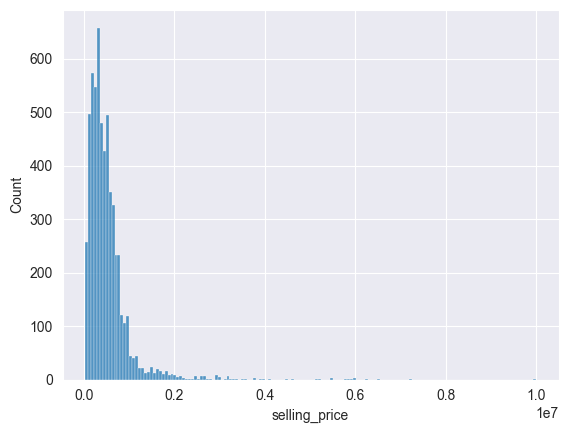

In [42]:
sns.histplot(df_train["selling_price"])
plt.show()

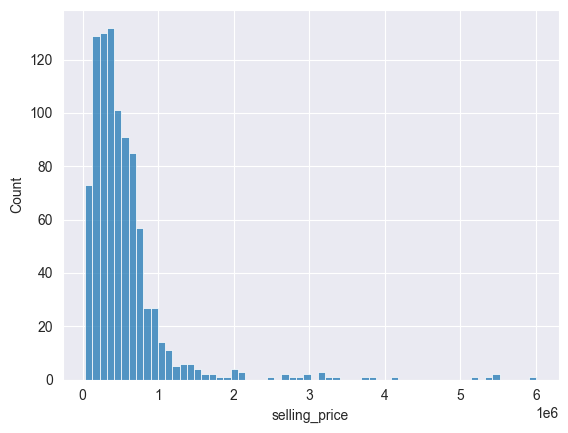

In [43]:
sns.histplot(df_test["selling_price"])
plt.show()

In [44]:


df_train["log_selling_price"] = np.log1p(df_train["selling_price"])
df_test["log_selling_price"] = np.log1p(df_test["selling_price"])

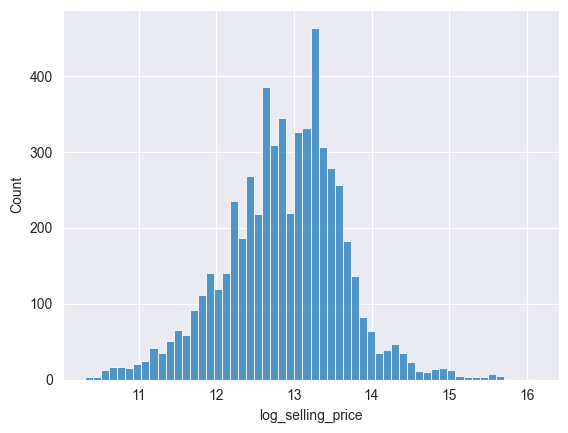

In [45]:
sns.histplot(df_train["log_selling_price"])
plt.show()

> #### Цена автомобилей сильно правосторонне смещено, но при логарифмировании становится нормальным распределением, что для модели намного понятнее чем просто `selling_price`, поэтому дальше работа будет производиться именно с `log_selling_price` новой колонкой.

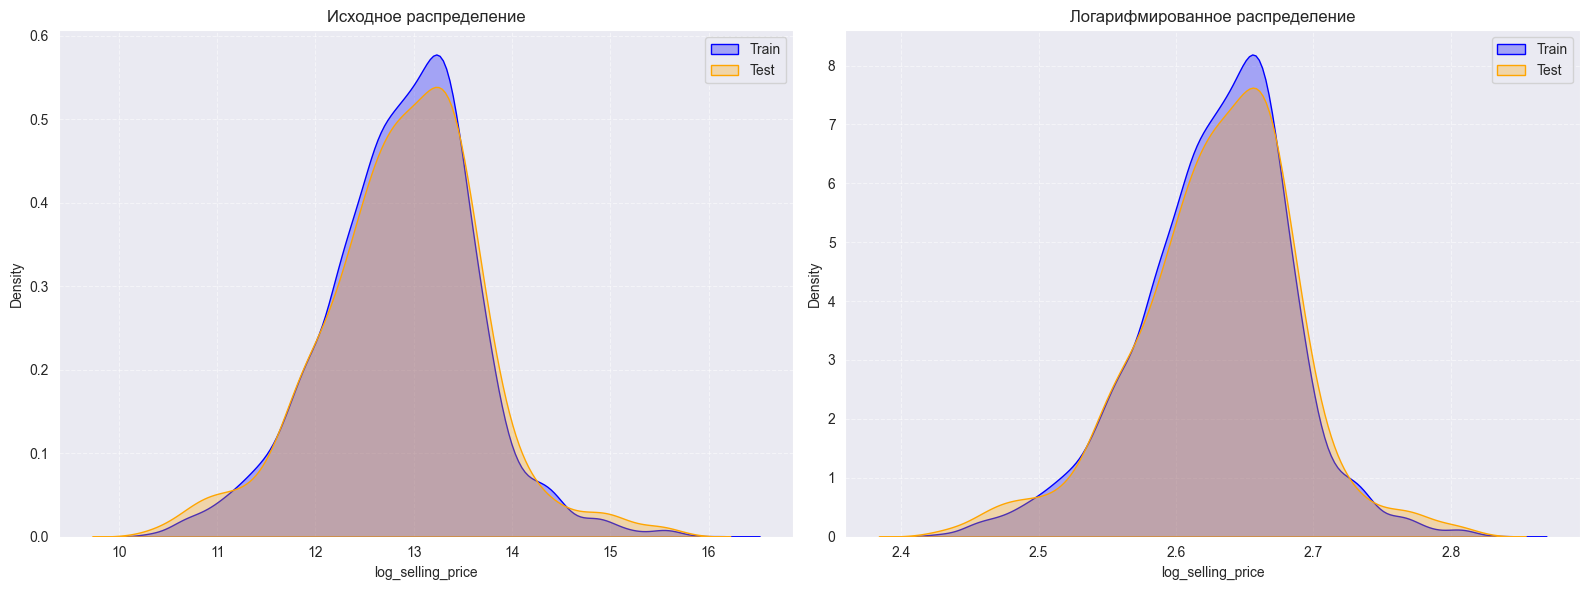

In [46]:
plot_target_distribution(df_train, df_test, "log_selling_price")

> #### `Train`, `Test` отлично распределены по логарифму цены - хороший знак того, что при проверки модели сюрпризов не будет

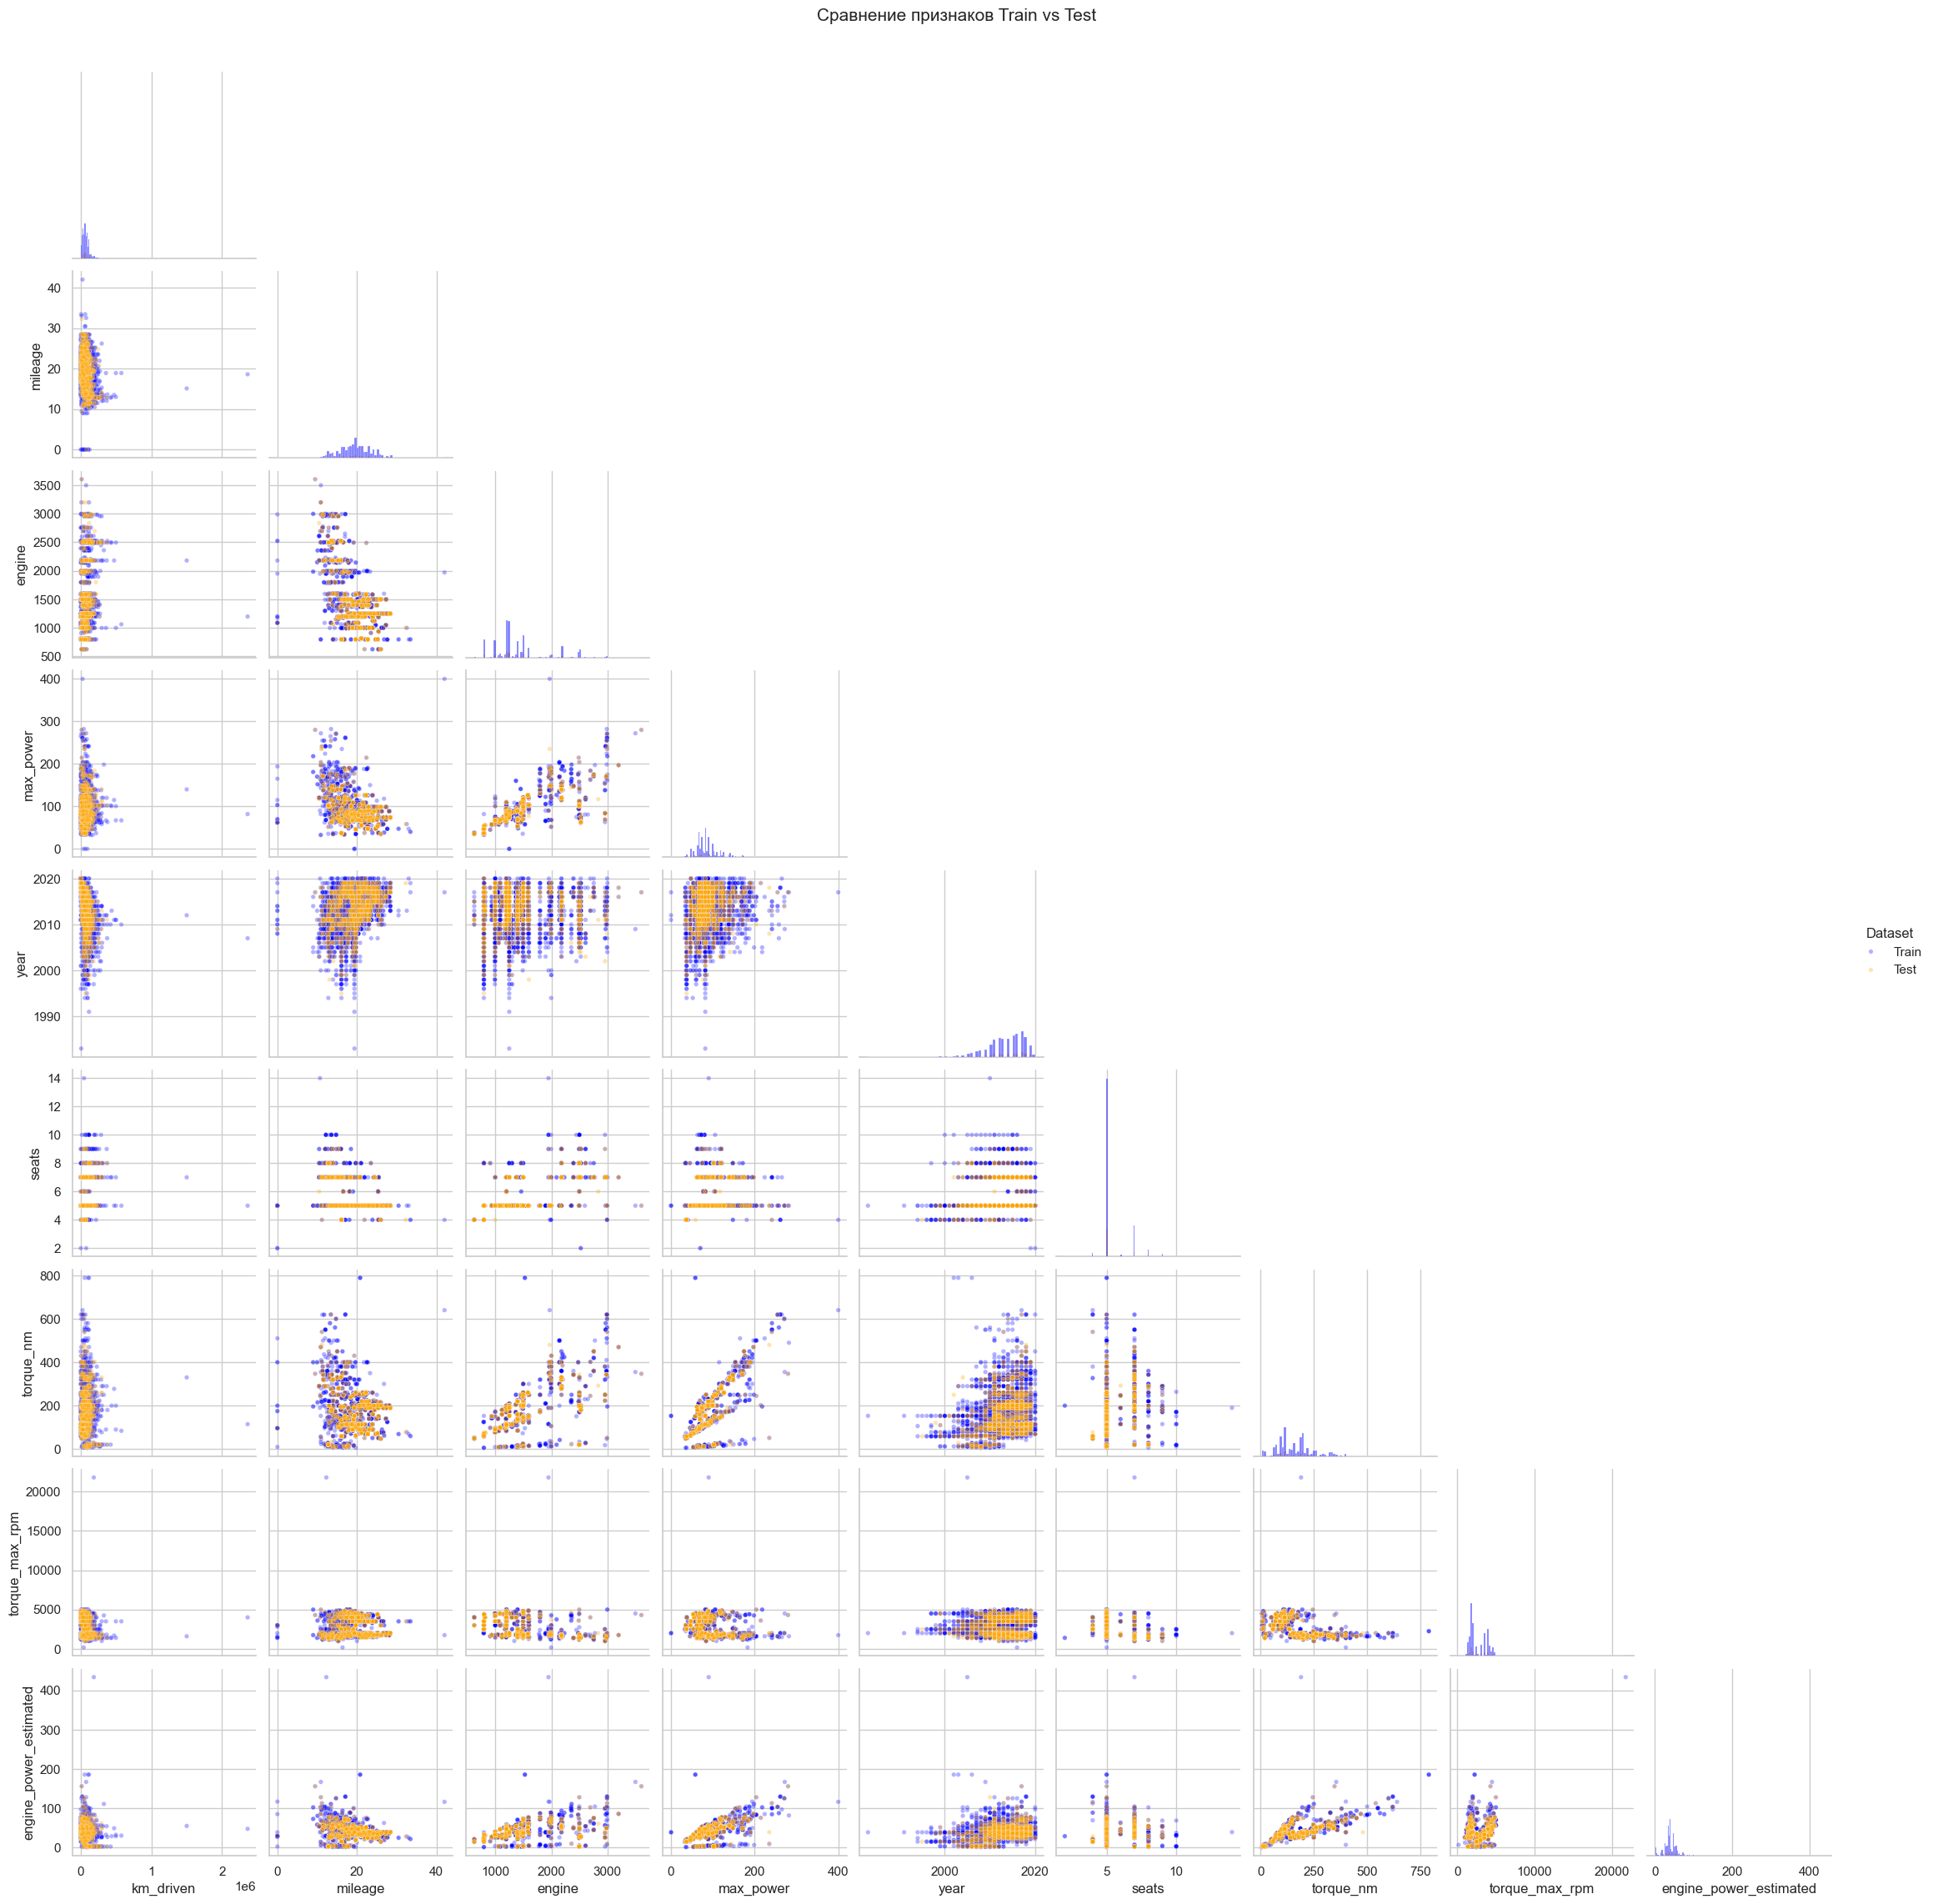

In [47]:
plot_train_test_pair_plot(df_train, df_test, NUM_COLS)

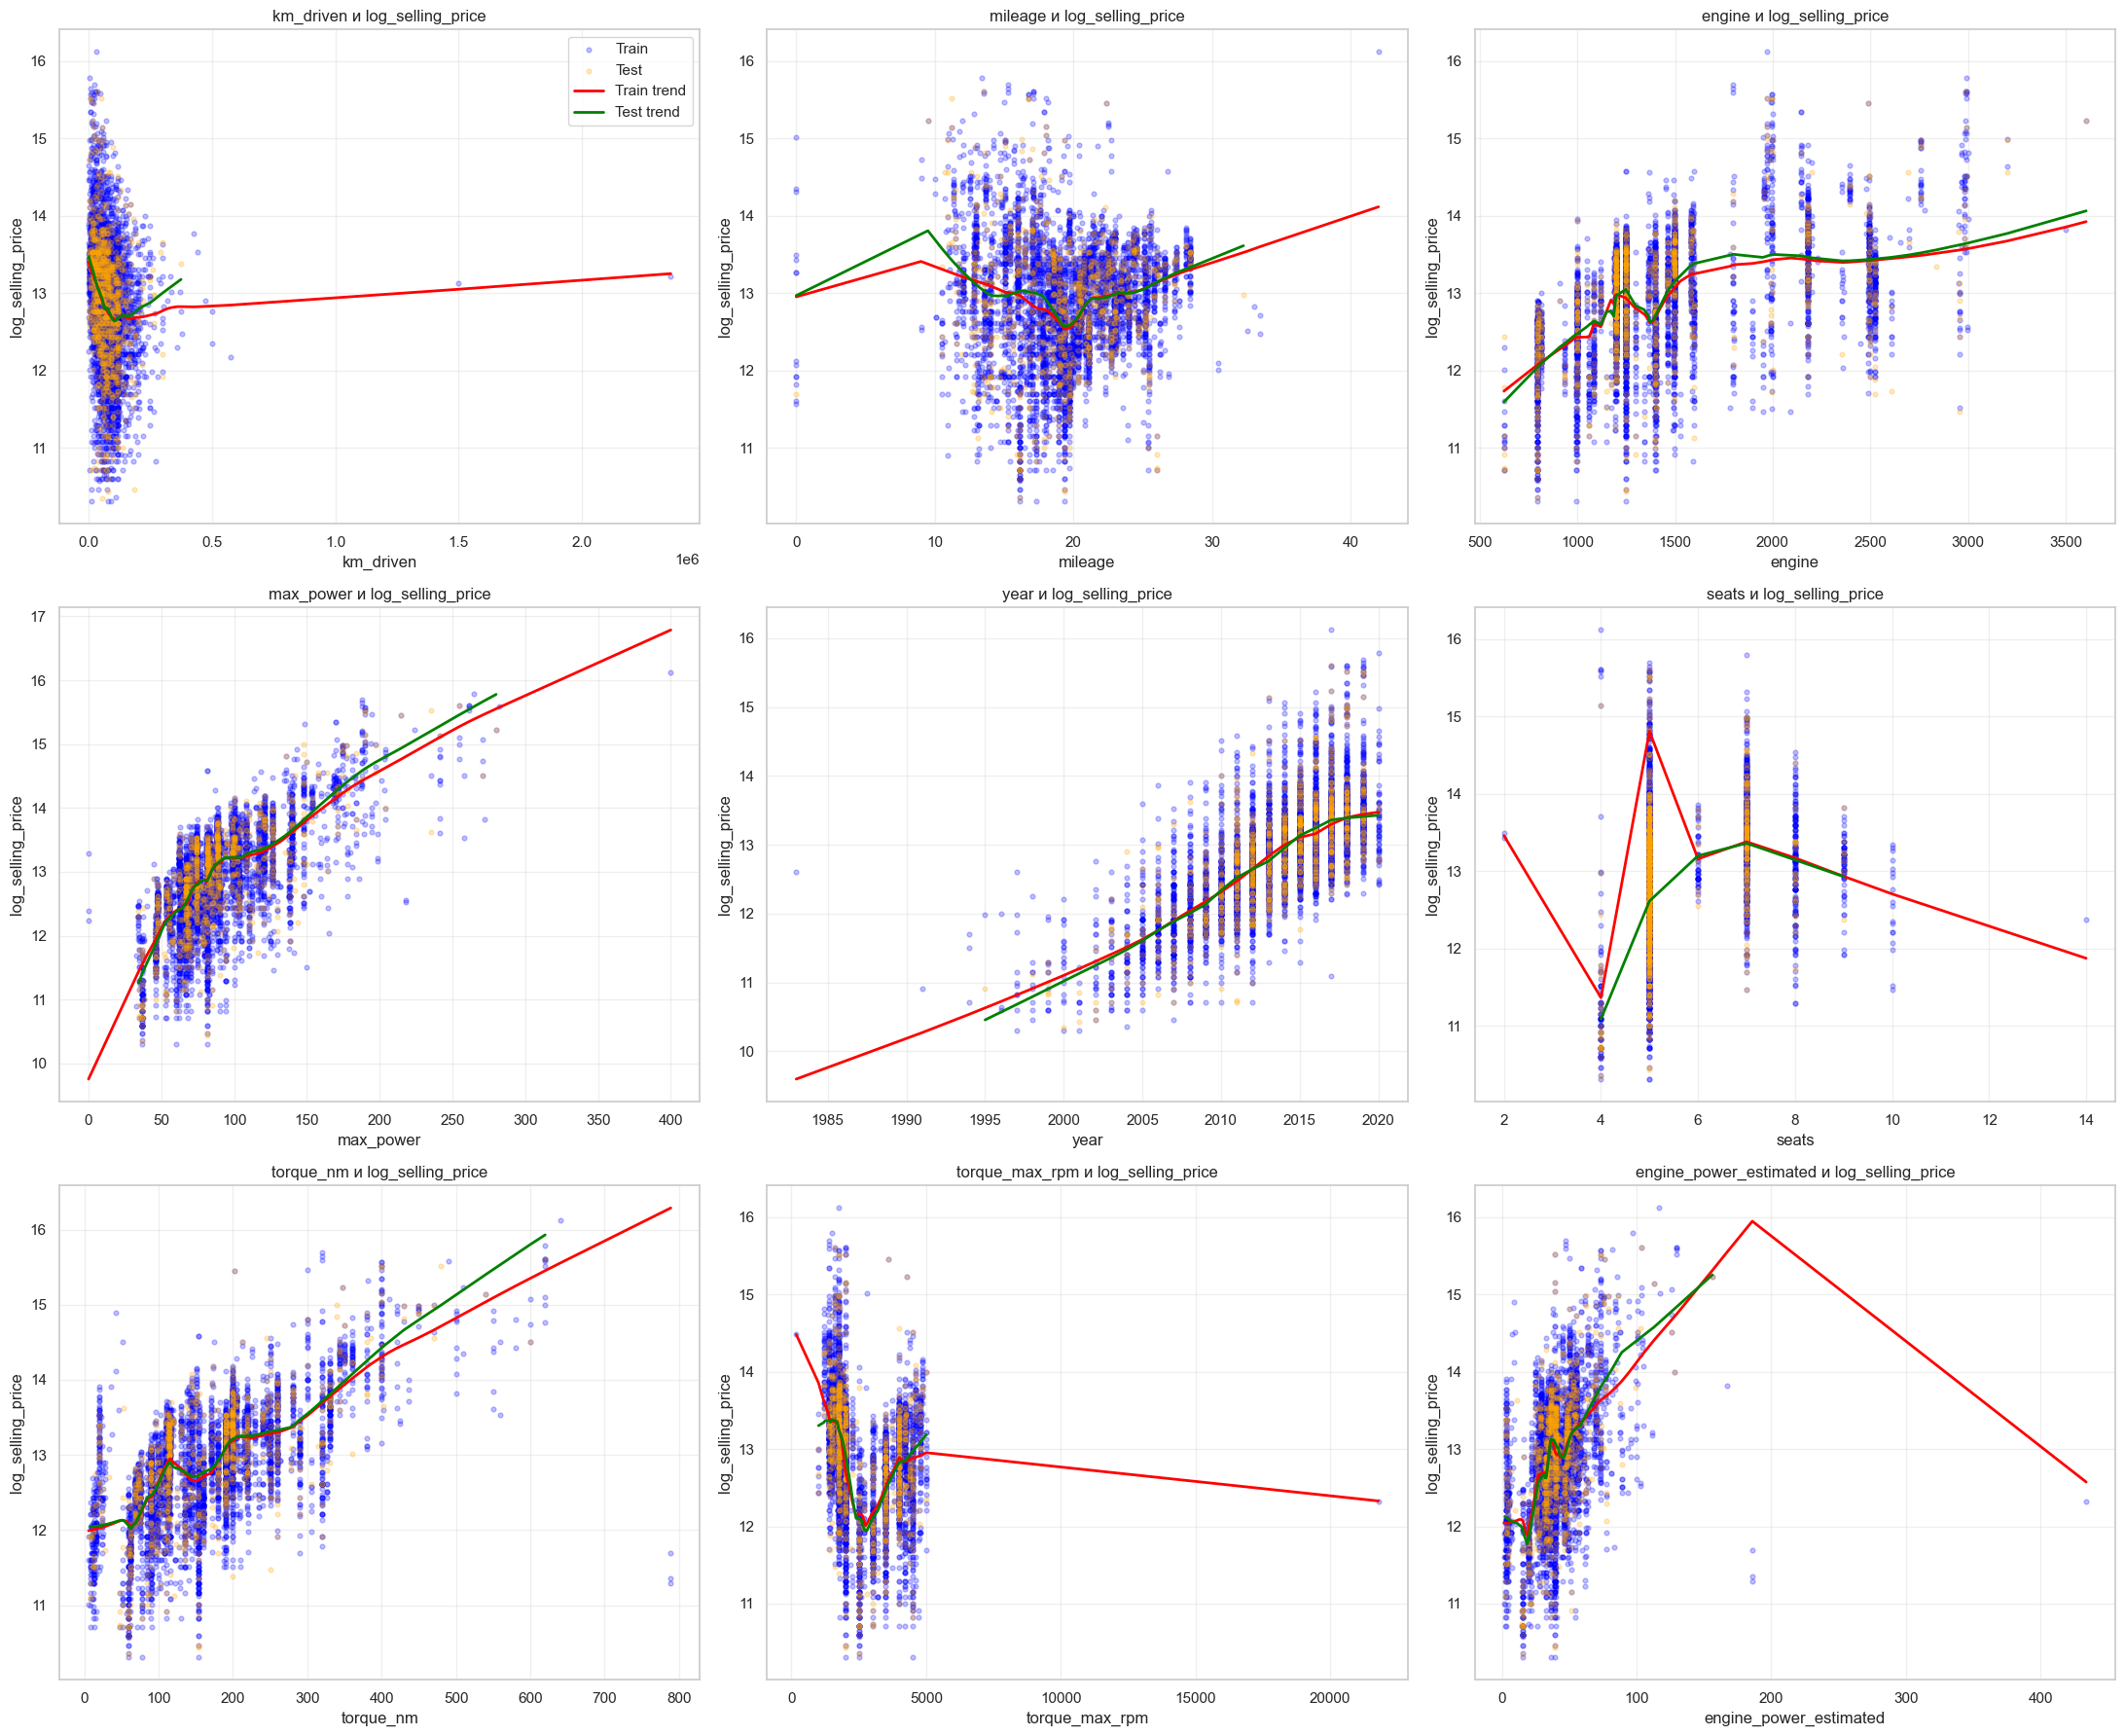

In [48]:
plot_feature_target_relationships_overlay(df_train, df_test, NUM_COLS, "log_selling_price")

## Связь признаков с целевой переменной (`log_selling_price`)

### **Признаки двигателя — ключевые драйверы стоимости**
- `engine`, `max_power`, `torque_nm` растут, цена тоже растёт.  
- После логарифмирования зависимость становится почти линейной, модели будет проще учить.  
- Это самые сильные и системные зависимости среди всех признаков.

---

### **Возраст автомобиля (`year`)**
- Новее, значит дороже.  
- Зависимость стабильная, чёткая, без сильных выбросов.  
- Один из наиболее важных факторов после характеристик двигателя.

---

### **Пробег (`km_driven`)**
- Больше пробег, ниже цена.  
- Связь есть, но шумная, из-за сильных выбросов в Train (в Test выбросов меньше).  
- После логарифма связь становится гладкой, но всё равно средняя по силе.

---

### **Экономичность (`mileage`)**
- Тренд слабый и нелинейный.  
- В нижней части графика есть небольшое снижение цены, но дальше сигнал теряется.  
- Влияние минимальное по сравнению с мощностью или возрастом.

---

### **Количество сидений (`seats`)**
- Очень слабая связь.  
- Большинство авто имеют 4–5 мест, поэтому признак почти константный.  
- Влияние на цену малозначимое.

---

### **`torque_max_rpm`**
- Почти полностью шумный признак.  
- Системной зависимости с ценой нет.  
- Может быть полезен только в комбинациях, но сам по себе слабый.

---

## Можно ли предположить корреляции по распределениям фичей?

### **Сильные корреляции (технические признаки)**
- `engine` и `max_power`  
- `engine` и `torque_nm`  
- `max_power` и `torque_nm`  

Эти зависимости естественные: характеристики двигателя растут вместе.

---

### **Слабые или отсутствующие корреляции**
- `mileage`  
- `seats`  
- `torque_max_rpm`  

Эти признаки либо дискретные, либо шумные, либо не связаны напрямую с другими характеристиками.

---

## Сравнение Train и Test

### **Сходство распределений**
- Train и Test похожи.  
- Это важно: модель сможет стабильно работать на тесте, если её не переобучить.

---

### **Отличия**
- В Train больше экстремальных значений (`km_driven`, `engine`, `max_power`).  
- Test выглядит “чище” и однороднее.

### **Задание 7 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [✅] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [✅] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)


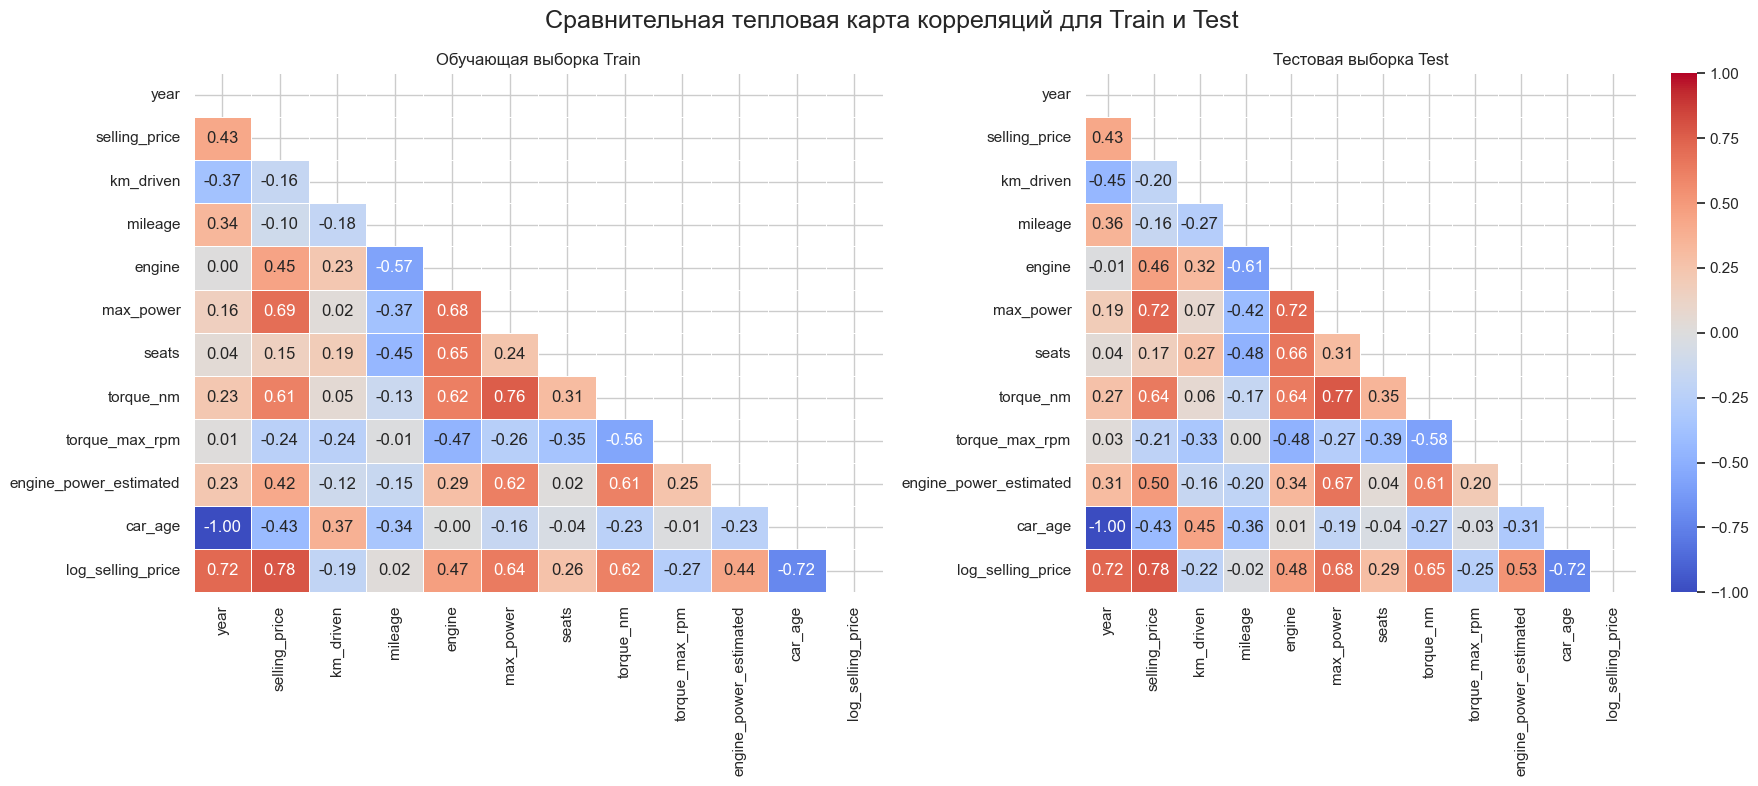

In [49]:
compare_corr_heatmap(df_train, df_test, "Сравнительная тепловая карта корреляций для Train и Test")

- [✅] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

### Анализ корреляционных гипотез

#### 1. Какие 2 признака наименее скоррелированы между собой?
> Признаки `year` и `engine` наименее скоррелированны. **Корреляция 0.00.**
> *Интерпретация:* Объём двигателя никак не связан с годом выпуска.

#### 2. Между какими наблюдается довольно сильная положительная линейная зависимость?
> Между `max_power` и `torque_nm` наблюдается корреляция **0.74** на Train, **0.76** на Test довольно высоко, но не 1.
> *Интерпретация:* Чем выше мощность, тем выше крутящий момент

#### 3. Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
> **Да, можно так сказать.** Из-за шумов корреляция лишь **-0.37** на Train, **−0.43** на Test (отрицательно умеренная), но тренд хороший на верность предположения.

### **Бонус (0.5 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их **и поясните.**

- Каждая дополнительная визуализация может принести до 0.25 баллов при условии, что она обоснована.

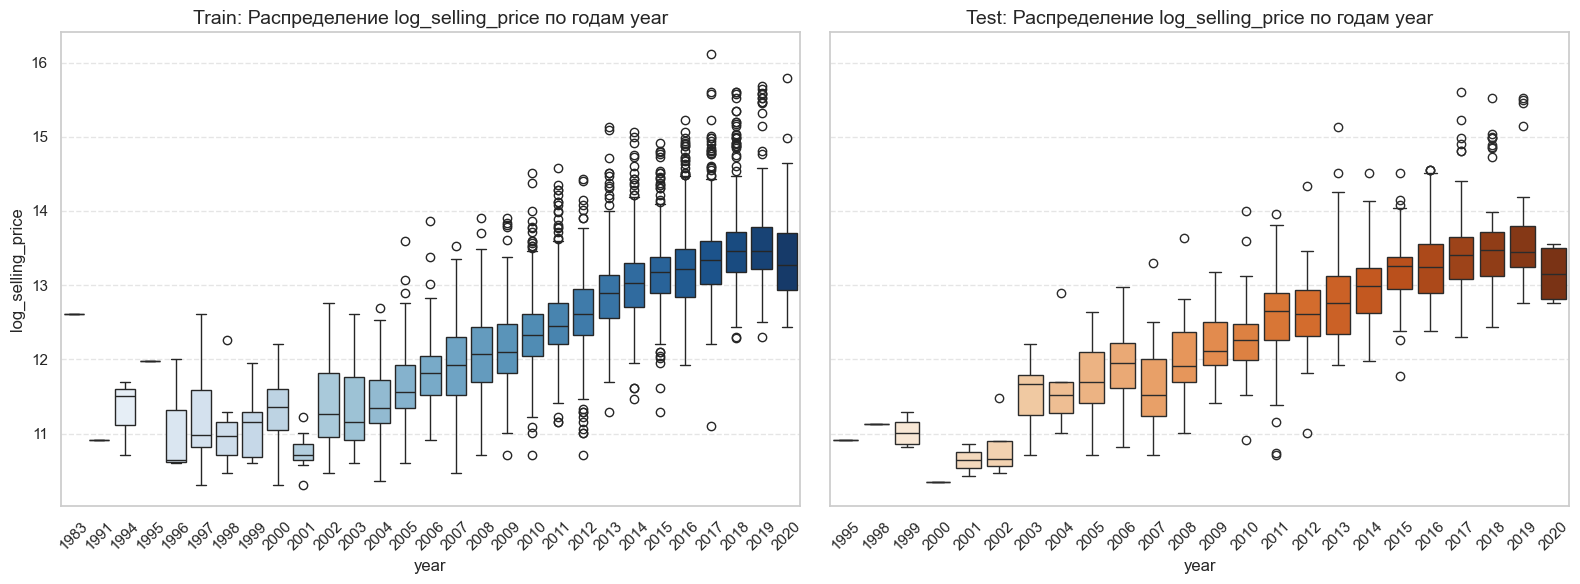

In [50]:
plot_box_comparison(df_train, df_test, "year", "log_selling_price", "Распределение log_selling_price по годам")

> ### В целом видно что тренд к стабильному увеличению цены на авто начинается где-то с 2004 года. С 2009 года очень много выбросов. Это премиальные модели, которые нетипичный для страны где собирали датасеты они очень выделяются. На `Train` более стабильный рост, на `Test` можно увидеть просадки в 2007 году.Выбросов в `Test` становится много лишь с 2017 года.

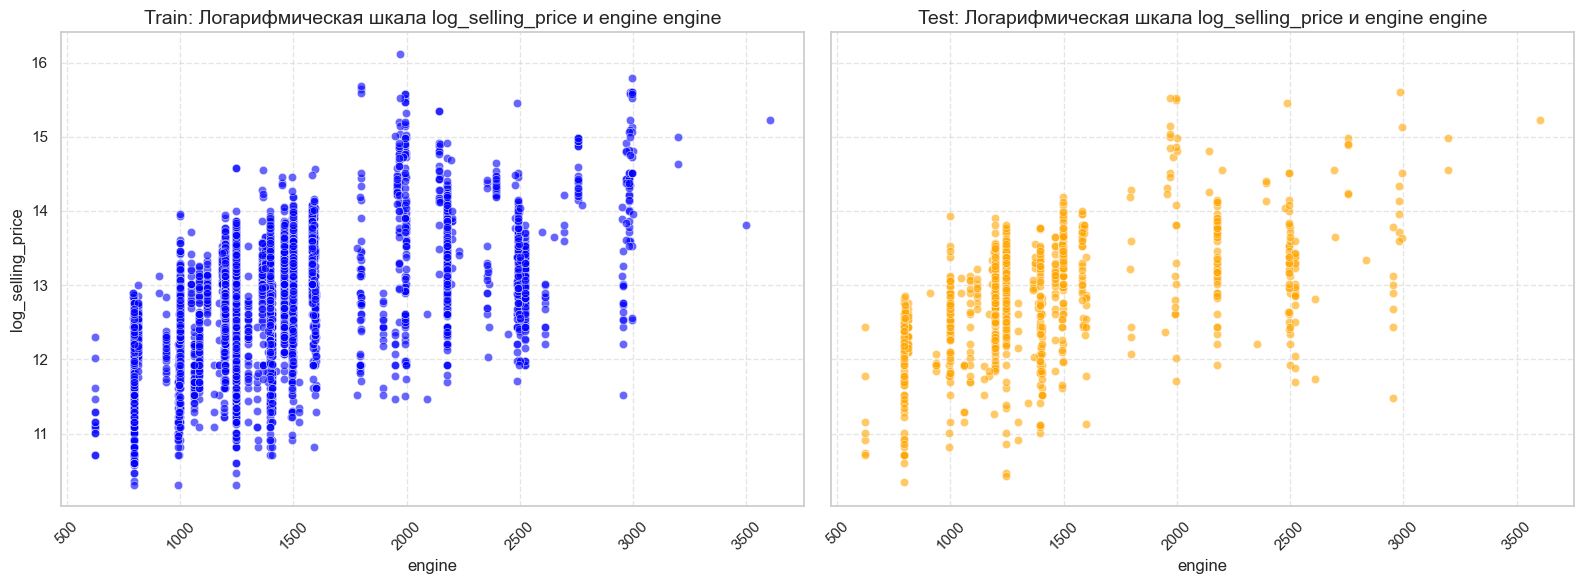

In [51]:
plot_scatter_comparison(df_train, df_test, "engine", "log_selling_price",
                        "Логарифмическая шкала log_selling_price и engine")

> ### После лог-преобразования selling_price зависимость от engine становится почти линейной. engine - очень важный признак. И в `Train` и `Test` хорошая линия вычерчивается.

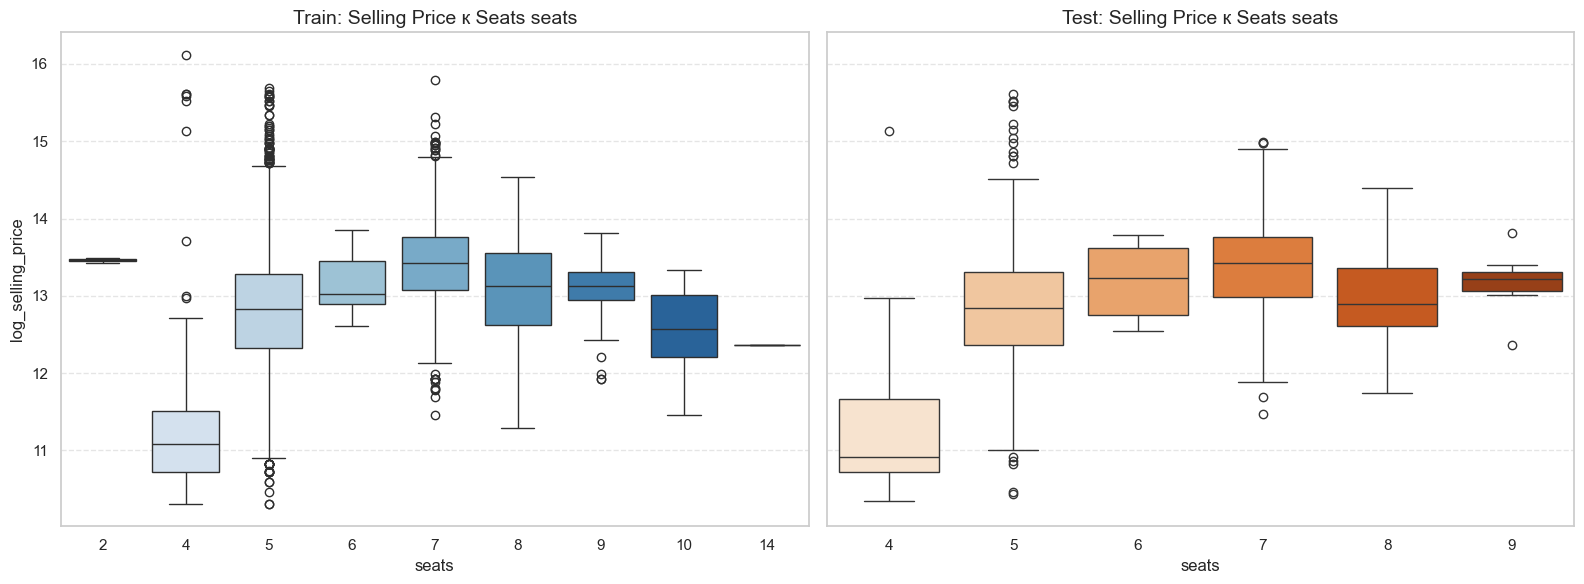

In [52]:
box_plot_for_categories(df_train, df_test, "seats", "log_selling_price", "Selling Price к Seats")

> ### Цена растёт вместе с числом сидений: 7-местные и 8-местные машины дороже, ем 5-местные, но 9-10-местные падают по цене.. Почему? Пока не понятно, ведь по идее автобусы стоят дороже.  И `Train` и `Test` почти не отличаются, данных меньше для `Test`.

# **Часть 2 | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.25 балла;

### **Задание 8 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [53]:
X_train_num = df_train.select_dtypes(exclude=[object]).copy()
X_test_num = df_test.select_dtypes(exclude=[object]).copy()

In [54]:
y_train = X_train_num["log_selling_price"]
y_test = X_train_num["log_selling_price"]

In [55]:
X_train_num = X_train_num.drop(["selling_price", "log_selling_price", "year"], axis=1)
X_test_num = X_test_num.drop(["selling_price", "log_selling_price", "year"], axis=1)

In [56]:
assert X_train_num.shape == (5840, 9)

In [57]:
assert X_test_num.shape == (931, 9)

In [58]:
X_train_regression, X_validation_regression, y_train_regression, y_validation_regression = train_test_split(
    X_train_num,
    y_train,
    test_size=0.2,
    random_state=42
)

display(Markdown(f"### Размер Train после разделения: {X_train_regression.shape}"))
display(Markdown(f"###Размер Validation после разделения: {X_validation_regression.shape}"))

### Размер Train после разделения: (4672, 9)

###Размер Validation после разделения: (1168, 9)

### **Задание 9 (0.2 балла)**

Построим нашу первую модель!
- [✅] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [✅] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [59]:
result_default_lr = evaluate_regression(
    model=LinearRegression(),
    X_train=X_train_regression,
    y_train_log=y_train_regression,
    X_val=X_validation_regression,
    y_val_log=y_validation_regression,
    model_name="Дефолтная Линейная Регрессия",
    scaler=None,
)

### Дефолтная Линейная Регрессия

- **RMSE:** `458,213.41733`

- **MAE:** `129,862.08399`

- **R²:** `0.41939`

---

### Вывод по метрикам после обучения ЛР без гиперпараметров

> **1. Качество модели ($R^2 \approx 0.33$):**
> Текущая базовая модель объясняет лишь **33% дисперсии цены**, что является низким показателем. Это указывает на **недообучение (underfitting)**: модели не хватает информации для построения точных прогнозов.
> *Вероятная причина* — отсутствие в обучающей выборке важных категориальных признаков, которые мы пока исключили.

> **2. Анализ ошибок (RMSE vs MAE):**
> * **MAE $\approx$ 132 000:** В среднем модель ошибается на 132 тысячи. Для бюджетного сегмента это приемлемая точность.
> * **RMSE $\approx$ 489 000:** Высокое значение RMSE показывает наличие **сильных выбросов** или отдельных грубых ошибок прогнозирования на дорогих автомобилях.

### **Задание 10 (0.15 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [✅] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [60]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_regression)
X_val_scaled = scaler.transform(X_validation_regression)

result_default_lr_scaled = evaluate_regression(
    model=LinearRegression(),
    X_train=X_train_regression,
    y_train_log=y_train_regression,
    X_val=X_validation_regression,
    y_val_log=y_validation_regression,
    model_name="Дефолтная Линейная Регрессия после стандартизации",
    scaler=scaler,
)

### Дефолтная Линейная Регрессия после стандартизации

- **RMSE:** `458,213.41733`

- **MAE:** `129,862.08399`

- **R²:** `0.41939`

---

> ### Вывод по масштабированию:
Применение стандартизации не привело к изменению метрик качества для классической ЛР. Масштабы признаков не влияют на ЛР. Модель автоматически скомпенсировала изменение масштаба входных данных пропорциональным изменением своих коэффициентов (весов), в результате чего итоговые предсказания остались теми же.

### **Задание 11 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [✅] Какой признак оказался наиболее информативным в предсказании цены?

In [61]:
model_default_lr_scaled = result_default_lr_scaled["FittedModel"]
weights = pd.DataFrame({
    'Признак': X_train_regression.columns,
    'Вес': model_default_lr_scaled.coef_
})

weights = weights.sort_values(by='Вес', key=abs, ascending=False)
display(Markdown(f"### Влияния признаков на цену по убыванию после стандартизации ЛР:"))
display(weights)

### Влияния признаков на цену по убыванию после стандартизации ЛР:

,Признак,Вес
8,car_age,-0.455587
3,max_power,0.320757
2,engine,0.139655
6,torque_max_rpm,-0.104676
1,mileage,0.057381
5,torque_nm,-0.053332
7,engine_power_estimated,0.050232
0,km_driven,-0.043546
4,seats,0.024235


> ### Вывод по признакам, влияющим на цену после ЛР с дефолтными параметрами:
Наиболее информативным окозался признак car_age, чем старше машина, сильнее падает цена. Обратная зависимость. Также неплоо влияет на цену и max_power т.е чем больше мощность, тем выше цена.

### **Задание 12 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [✅] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [✅] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [62]:
result_lr_L1 = evaluate_regression(
    model=Lasso(),
    X_train=X_train_regression,
    y_train_log=y_train_regression,
    X_val=X_validation_regression,
    y_val_log=y_validation_regression,
    model_name="Дефолтная Линейная Регрессия после стандартизации",
    scaler=scaler,
)

### Дефолтная Линейная Регрессия после стандартизации

- **RMSE:** `617,772.89669`

- **MAE:** `292,520.93467`

- **R²:** `-0.05538`

---

In [63]:
model_lr_L1 = result_lr_L1["FittedModel"]
lasso_weights = pd.DataFrame({
    'Признак': X_train_regression.columns,
    'Вес Lasso': model_lr_L1.coef_
}).sort_values(by='Вес Lasso', key=abs, ascending=False)

display(Markdown(f"### Влияния признаков на цену по убыванию L1:"))
display(lasso_weights)

### Влияния признаков на цену по убыванию L1:

,Признак,Вес Lasso
0,km_driven,-0.0
1,mileage,0.0
2,engine,0.0
3,max_power,0.0
4,seats,0.0
5,torque_nm,0.0
6,torque_max_rpm,-0.0
7,engine_power_estimated,0.0
8,car_age,-0.0


> ### При использовании Lasso-регрессии (L1-регуляризация) с параметром `alpha` по умолчанию есть сильный упадок качества: R² стал отрицательным, RMSE увеличился, коэффициенты модели занулились.
L1 накладывает сильный штраф на абсолютные значения весов и при слишком большом `alpha` модель фактически "выключает" все признаки.В наборе данных присутствует мультиколлинеарность, из-за чего Lasso нестабильна: она выбирает один признак из группы коррелирующих, а остальные зануляет, что ухудшает качество модели.

### **Задание 13 Финальный рывок (0.5 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [✅] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [✅] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [64]:
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2000]}

lasso_model = Lasso(random_state=42)

grid_search_lasso = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)

In [65]:
result_lr_L1_grid_searched = evaluate_regression(
    model=grid_search_lasso,
    X_train=X_train_regression,
    y_train_log=y_train_regression,
    X_val=X_validation_regression,
    y_val_log=y_validation_regression,
    model_name="Линейная Регрессия c регуляризацией L1",
    scaler=scaler,
)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


### Линейная Регрессия c регуляризацией L1

- **RMSE:** `350,711.29450`

- **MAE:** `127,482.17106`

- **R²:** `0.65986`

---

In [66]:
best_model = result_lr_L1_grid_searched["FittedModel"].best_estimator_

coefs = best_model.coef_
zero_coefs_count = np.sum(coefs == 0)
best_alpha = best_model.alpha

n_alphas = len(param_grid['alpha'])
n_folds = 10
total_models = n_alphas * n_folds

In [67]:
display(Markdown(f"* #### Лучший коэффициент регуляризации alpha: {best_alpha}"))
display(Markdown(f"* #### Количество зануленных весов: {zero_coefs_count}"))
display(Markdown(f"* #### Всего признаков: {len(coefs)}"))
display(Markdown(f"* #### Всего обучено моделей: {total_models}"))

* #### Лучший коэффициент регуляризации alpha: 0.01

* #### Количество зануленных весов: 1

* #### Всего признаков: 9

* #### Всего обучено моделей: 120

> ### GridSearchCV перебрал 120 моделей и нашёл оптимальный коэффициент регуляризации alpha=0.01. Ни один из коэффициентов не был занулён.
Признаковая матрица содержит сильные информативные признаки, и модель достигает лучшего качества при очень слабой регуляризации. Сильная регуляризация ухудшила метрики в Lasso, а маленькая (alpha=0.01) давала наилучший баланс смещения и разброса.

In [68]:
lasso_weights = pd.DataFrame({
    'Признак': X_train_regression.columns,
    'Вес Lasso': best_model.coef_
}).sort_values(by='Вес Lasso', key=abs, ascending=False)

display(Markdown(f"### Влияния признаков на цену по убыванию L1, после оптимального поиска гиперпараметра:"))
display(lasso_weights)

### Влияния признаков на цену по убыванию L1, после оптимального поиска гиперпараметра:

,Признак,Вес Lasso
8,car_age,-0.462492
3,max_power,0.305778
2,engine,0.126593
6,torque_max_rpm,-0.058319
1,mileage,0.029298
0,km_driven,-0.026046
5,torque_nm,0.013568
4,seats,0.006602
7,engine_power_estimated,0.000000


> ### GridSearchCV показал хорошие метрики и они улучшились, так как GridSearchCV грамотно подобрал гиперпараметр alpha.

**Ваша задача 2:**

- [✅] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [✅] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [69]:
param_grid_elastic = {
    'alpha': [0.01, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}

elastic_model = ElasticNet(random_state=42)

grid_search_elastic = GridSearchCV(
    estimator=elastic_model,
    param_grid=param_grid_elastic,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [70]:
result_lr_elastic_grid_searched = evaluate_regression(
    model=grid_search_elastic,
    X_train=X_train_regression,
    y_train_log=y_train_regression,
    X_val=X_validation_regression,
    y_val_log=y_validation_regression,
    model_name="Линейная Регрессия c регуляризацией ElasticNet",
    scaler=scaler,
)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


### Линейная Регрессия c регуляризацией ElasticNet

- **RMSE:** `426,973.21236`

- **MAE:** `129,663.14968`

- **R²:** `0.49586`

---

In [71]:
best_params_elastic = result_lr_elastic_grid_searched["FittedModel"]
best_model_elastic = result_lr_elastic_grid_searched["FittedModel"].best_estimator_

coefs = best_model_elastic.coef_
zero_coefs_count = np.sum(coefs == 0)
best_alpha = best_model_elastic.alpha

n_alphas = len(param_grid['alpha'])
n_folds = 10
total_models = n_alphas * n_folds

In [72]:
display(
    Markdown(f"* #### Лучшие параметры ElasticNet, с поиском гиперпараметров: **{best_params_elastic.best_params_}**"))
display(Markdown(
    f"* #### Всего обучено моделей ElasticNet, с поиском гиперпараметров: **{len(param_grid_elastic['alpha']) * len(param_grid_elastic['l1_ratio']) * 10}**"))
display(Markdown(f"* #### Лучший коэффициент регуляризации alpha: {best_alpha}"))
display(Markdown(f"* #### Количество зануленных весов: {zero_coefs_count}"))
display(Markdown(f"* #### Всего признаков: {len(coefs)}"))
display(Markdown(f"* #### Всего обучено моделей: {total_models}"))

* #### Лучшие параметры ElasticNet, с поиском гиперпараметров: **{'alpha': 0.01, 'l1_ratio': 0.1}**

* #### Всего обучено моделей ElasticNet, с поиском гиперпараметров: **250**

* #### Лучший коэффициент регуляризации alpha: 0.01

* #### Количество зануленных весов: 0

* #### Всего признаков: 9

* #### Всего обучено моделей: 120

> ### GridSearchCV обучил 250 моделей так как 2 параметра их длины перемножаются и еще фолды. Лучшими параметрами модель посчитала 'alpha': 0.01, 'l1_ratio': 0.1. Все метрики стали хуже.

In [73]:
lasso_weights = pd.DataFrame({
    "Признак": X_train_regression.columns,
    "Вес Lasso": best_model_elastic.coef_
}).sort_values(by="Вес Lasso", key=abs, ascending=False)

display(Markdown(f"### Влияния признаков на цену по убыванию ElasticNet:"))
display(lasso_weights)

### Влияния признаков на цену по убыванию ElasticNet:

,Признак,Вес Lasso
8,car_age,-0.449983
3,max_power,0.306485
2,engine,0.140829
6,torque_max_rpm,-0.070695
1,mileage,0.054529
0,km_driven,-0.042078
4,seats,0.021099
7,engine_power_estimated,0.018544
5,torque_nm,-0.000741


> ### ElasticNet одновременно использует L1 и L2 штрафы. Дополнительный L2-штраф сгладил и уменьшил коэффициенты, что привело к падению качества. ElasticNet здесь избыточен — обычная линейная регрессия без регуляризации работает лучше.

# **Часть 3| Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.75 основных балла и 0.25 бонусных.


**Задание 14 (0.1 балла)** Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

В этом домашнем задании мы предлагаем удалить его.

**Ваша задача:**
- [❌] Удалить столбец`name`

В другом случае, конечно, мы могли бы предобработать данный столбец. В качестве бонуса предлагаем вам придумать и реализовать алгоритм предобработки.

**Бонус 0.25 балла**
- [✅] Предобработайте столбец `name`, чтобы избежать его удаления. Если предобработали столбец — можно закомментировать assert

In [74]:
X_train = df_train.copy()
X_test = df_test.copy()

In [75]:
%time
X_train["brand"] = X_train["name"].apply(extract_brand)

CPU times: total: 0 ns
Wall time: 5.72 μs


In [76]:
display(Markdown(f"### Количество уникальных категорий в признаке **brand**: "))
display(X_train["brand"].value_counts())

### Количество уникальных категорий в признаке **brand**: 

brand
Maruti           1804
Hyundai          1058
Mahindra          611
Tata              534
Toyota            309
Ford              308
Honda             308
Chevrolet         188
Renault           171
Volkswagen        153
Nissan             63
Skoda              61
Datsun             49
Mercedes-Benz      44
BMW                41
Fiat               39
Audi               31
Jeep               20
Mitsubishi          8
Volvo               8
Jaguar              7
Force               4
Isuzu               4
Land                3
Kia                 3
MG                  3
Ambassador          3
Daewoo              3
Lexus               1
Peugeot             1
Name: count, dtype: int64

In [77]:
%time
X_train["brand"] = X_train["name"].str.split(" ").str[0]

CPU times: total: 0 ns
Wall time: 4.29 μs


> #### Готовые Pandas атрибуты работают быстрее, чем самописные функции, это очень хорошо

In [78]:
double_named_brend = {
    "Land": "Land Rover",
}

X_train["brand"] = X_train["brand"].replace(double_named_brend)

display(Markdown(f"### Количество уникальных категорий в признаке **brand**: "))
display(X_train["brand"].value_counts())

### Количество уникальных категорий в признаке **brand**: 

brand
Maruti           1804
Hyundai          1058
Mahindra          611
Tata              534
Toyota            309
Ford              308
Honda             308
Chevrolet         188
Renault           171
Volkswagen        153
Nissan             63
Skoda              61
Datsun             49
Mercedes-Benz      44
BMW                41
Fiat               39
Audi               31
Jeep               20
Mitsubishi          8
Volvo               8
Jaguar              7
Force               4
Isuzu               4
Land Rover          3
Kia                 3
MG                  3
Ambassador          3
Daewoo              3
Lexus               1
Peugeot             1
Name: count, dtype: int64

> #### Сделал маппинг для авто с 2 словами в марке. Тут увидел только Land Rover поэтому dict маленький

In [79]:
X_train.drop("name", axis=1, inplace=True)

In [80]:
X_train_before_OHE = X_train

In [81]:
display(Markdown(f"* #### Статистика по категориальным признакам: "))
display(X_train.describe(include=object))

* #### Статистика по категориальным признакам: 

,fuel,seller_type,transmission,owner,brand
count,5840,5840,5840,5840,5840
unique,4,3,2,5,30
top,Diesel,Individual,Manual,First Owner,Maruti
freq,3177,5223,5336,3603,1804


In [82]:
X_test["brand"] = X_test["name"].str.split(" ").str[0]
X_test["brand"] = X_test["brand"].replace(double_named_brend)

In [83]:
X_test.drop("name", axis=1, inplace=True)

In [84]:
X_test_before_OHE = X_test

In [85]:
X_test.describe(include=object)

,fuel,seller_type,transmission,owner,brand
count,931,931,931,931,931
unique,4,3,2,5,25
top,Diesel,Individual,Manual,First Owner,Maruti
freq,498,813,839,562,276


> #### Видно, что марка Maruti очень популярная, марка Японская, но производится в Индии, скорее всего датасет собран из Индийских статистик

### **Задание 15 (0.4 балла)**

- [✅] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования. Обратите внимание, что во избежание мультиколлинеарности следует избавиться от одного из полученных столбцов при кодировании каждого признака методом OneHot.

In [86]:
X_train_encoded = pd.get_dummies(X_train, columns=CAT_COLS, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=CAT_COLS, drop_first=True)

In [87]:
y_test_real = X_test_encoded["selling_price"]
y_train_real = X_train_encoded["selling_price"]

In [88]:
X_train_encoded = X_train_encoded.drop(["selling_price", "log_selling_price", "year"], axis=1, errors="ignore")
X_test_encoded = X_test_encoded.drop(["selling_price", "log_selling_price", "year"], axis=1, errors="ignore")

In [89]:
X_train_after_OHE = X_train_encoded
columns_after_ohe = X_train_encoded.columns.tolist()

In [90]:
show_head_tail_data(X_train_encoded, "Train")

#### Первые 5 строк набора Train:

,km_driven,mileage,engine,max_power,seats,torque_nm,torque_max_rpm,engine_power_estimated,car_age,fuel_Diesel,...,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Peugeot,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo
0,145500,23.40,1248,74.00,5,190.00000,2000.0,39.794743,6,True,...,False,False,False,False,False,False,False,False,False,False
1,120000,21.14,1498,103.52,5,250.00000,1500.0,39.271128,6,True,...,False,False,False,False,False,True,False,False,False,False
2,127000,23.00,1396,90.00,5,219.66896,1750.0,40.257690,10,True,...,False,False,False,False,False,False,False,False,False,False
3,120000,16.10,1298,88.20,5,11.50000,4500.0,5.419416,13,False,...,False,False,False,False,False,False,False,False,False,False
4,45000,20.14,1197,81.86,5,113.75000,4000.0,47.648968,3,False,...,False,False,False,False,False,False,False,False,False,False


#### Последние 5 строк набора Train:

,km_driven,mileage,engine,max_power,seats,torque_nm,torque_max_rpm,engine_power_estimated,car_age,fuel_Diesel,...,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Peugeot,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo
5835,191000,17.92,1086,62.10,5,96.1,3000.0,30.191643,12,False,...,False,False,False,False,False,False,False,False,False,False
5836,50000,18.90,998,67.10,5,90.0,3500.0,32.987747,7,False,...,False,False,False,False,False,False,False,False,False,False
5837,110000,18.50,1197,82.85,5,113.7,4000.0,47.628024,7,False,...,False,False,False,False,False,False,False,False,False,False
5838,119000,16.80,1493,110.00,5,24.0,1900.0,4.775369,13,True,...,False,False,False,False,False,False,False,False,False,False
5839,120000,19.30,1248,73.90,5,190.0,2000.0,39.794743,11,True,...,False,False,False,False,False,False,False,False,False,False


In [91]:
show_head_tail_data(X_test_encoded, "Test")

#### Первые 5 строк набора Test:

,km_driven,mileage,engine,max_power,seats,torque_nm,torque_max_rpm,engine_power_estimated,car_age,fuel_Diesel,...,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Opel,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo
0,168000,14.0,2498,112.0,7,260.0,1800.0,49.010368,10,True,...,False,False,False,False,False,False,False,False,False,False
1,25000,21.5,1497,108.5,5,260.0,1500.0,40.841973,3,True,...,False,False,False,False,False,False,True,False,False,False
2,218463,12.9,1799,130.0,5,172.0,4300.0,77.453136,13,False,...,False,False,False,False,False,False,False,False,False,False
3,173000,25.1,1498,98.6,5,200.0,1750.0,36.653053,5,True,...,False,False,False,False,False,False,False,False,False,False
4,70000,16.5,1172,65.0,5,96.0,3000.0,30.160226,9,False,...,False,False,False,False,False,False,True,False,False,False


#### Последние 5 строк набора Test:

,km_driven,mileage,engine,max_power,seats,torque_nm,torque_max_rpm,engine_power_estimated,car_age,fuel_Diesel,...,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Opel,brand_Renault,brand_Skoda,brand_Tata,brand_Toyota,brand_Volkswagen,brand_Volvo
926,100000,19.81,1086,68.05,5,99.04000,4500.0,46.672950,12,False,...,False,False,False,False,False,False,False,False,False,False
927,50000,18.60,1197,81.83,5,114.70000,4000.0,48.046916,3,False,...,False,False,False,False,False,False,False,False,False,False
928,40000,23.00,1396,90.00,5,219.66896,1750.0,40.257690,11,True,...,False,False,False,False,False,False,False,False,False,False
929,25000,20.36,1197,78.90,5,111.80000,4000.0,46.832129,8,False,...,False,False,False,False,False,False,False,False,False,False
930,110000,26.00,1498,98.60,5,200.00000,1750.0,36.653053,4,True,...,False,False,False,False,False,False,False,False,False,False


In [92]:
train_cols = X_train_encoded.columns
X_test_encoded = X_test_encoded.reindex(columns=train_cols, fill_value=0)

In [93]:
X_test_encoded_after_OHE = X_test_encoded

In [94]:
X_train_regression, X_validation_regression, y_train_regression, y_validation_regression = train_test_split(
    X_train_encoded,
    y_train,
    test_size=0.2,
    random_state=42
)

display(Markdown(f"* #### Размер Train после разделения: {X_train_regression.shape}"))
display(Markdown(f"* #### Размер Validation после разделения: {X_validation_regression.shape}"))

* #### Размер Train после разделения: (4672, 48)

* #### Размер Validation после разделения: (1168, 48)

In [95]:
X_train_scaled = scaler.fit_transform(X_train_regression)
X_val_scaled = scaler.transform(X_validation_regression)

X_test_scaled = scaler.transform(X_test_encoded)

### **Задание 16 (0.25 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [✅] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [✅] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [96]:
param_grid_ridge = {
    "alpha": [0.01, 1, 10, 100, 1000, 2000]
}

ridge_model = Ridge(random_state=42)

grid_search_ridge = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid_ridge,
    cv=10,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

In [97]:
result_lr_ridge_grid_searched = evaluate_regression(
    model=grid_search_ridge,
    X_train=X_train_regression,
    y_train_log=y_train_regression,
    X_val=X_validation_regression,
    y_val_log=y_validation_regression,
    model_name="Линейная Регрессия c регуляризацией Ridge",
    scaler=scaler,
)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


### Линейная Регрессия c регуляризацией Ridge

- **RMSE:** `204,342.70771`

- **MAE:** `100,401.80760`

- **R²:** `0.88453`

---

In [98]:
best_params_ridge = result_lr_ridge_grid_searched["FittedModel"]
best_model_ridge = result_lr_ridge_grid_searched["FittedModel"].best_estimator_

coefs = best_model_ridge.coef_
zero_coefs_count = np.sum(coefs == 0)
best_alpha = best_model_ridge.alpha

n_alphas = len(param_grid['alpha'])
n_folds = 10
total_models = n_alphas * n_folds

In [99]:
display(Markdown(f"* #### Лучшие параметры Ridge, с поиском гиперпараметров: **{best_params_ridge.best_params_}**"))
display(Markdown(
    f"* #### Всего обучено моделей Ridge, с поиском гиперпараметров: **{len(param_grid_elastic['alpha']) * len(param_grid_elastic['l1_ratio']) * 10}**"))
display(Markdown(f"* #### Лучший коэффициент регуляризации alpha: {best_alpha}"))
display(Markdown(f"* #### Количество зануленных весов: {zero_coefs_count}"))
display(Markdown(f"* #### Всего признаков: {len(coefs)}"))
display(Markdown(f"* #### Всего обучено моделей: {total_models}"))

* #### Лучшие параметры Ridge, с поиском гиперпараметров: **{'alpha': 0.01}**

* #### Всего обучено моделей Ridge, с поиском гиперпараметров: **250**

* #### Лучший коэффициент регуляризации alpha: 0.01

* #### Количество зануленных весов: 0

* #### Всего признаков: 48

* #### Всего обучено моделей: 120

> ### Ridge-регрессия дала лучшие результаты среди всех линейных моделей.
GridSearchCV подобрал оптимальный параметр alpha = 0.01.
Модель показывает высокий R² на кросс-валидации (0.8817),
а также наименьшие ошибки RMSE и MAE по сравнению с Lasso и ElasticNet.
В данных есть мультиколлинеарность (engine–max_power–torque_nm),
а Ridge хорошо справляется с её подавлением, не зануляя информативные признаки.
В отличие от Lasso, Ridge не обнуляет коэффициенты, а сглаживает их,
что сохраняет вклад всех важных признаков и снижает переобучение.
Ridge дал сильный прирост качества.

In [100]:
y_val_real = np.expm1(y_validation_regression)
val_pred_log_ridge = best_model_ridge.predict(X_val_scaled)
val_pred_ridge_model = np.expm1(val_pred_log_ridge)

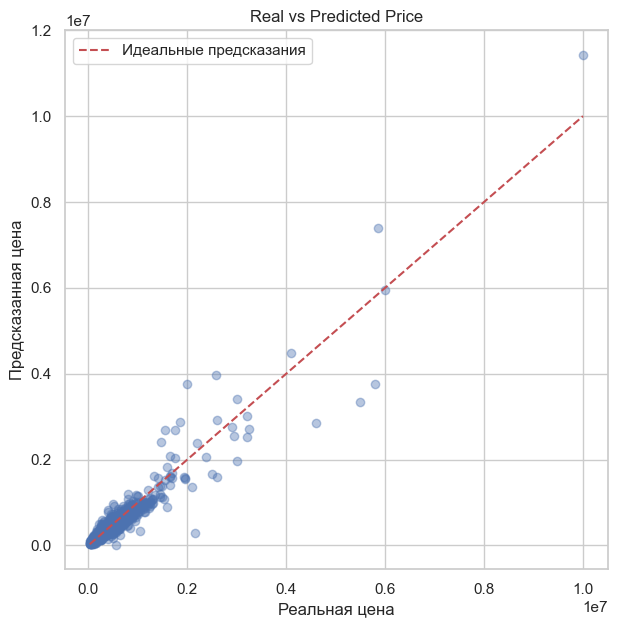

In [101]:
plt.figure(figsize=(7, 7))
plt.scatter(y_val_real, val_pred_ridge_model, alpha=0.4)
plt.plot([y_val_real.min(), y_val_real.max()],
         [y_val_real.min(), y_val_real.max()],
         'r--', label='Идеальные предсказания')

plt.xlabel("Реальная цена")
plt.ylabel("Предсказанная цена")
plt.title("Real vs Predicted Price")
plt.legend()
plt.grid(True)
plt.show()

> ### Модель попадает почти идеально в диапазон массовых машин (до ~1M).
На дорогих авто предсказывает хуже — заметное систематическое недооценивание. Линейная модель + лог-цены не справляются с премиальными ценами.

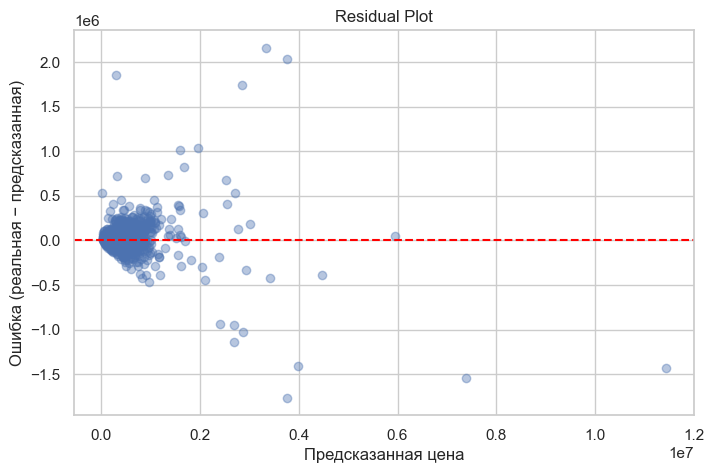

In [102]:
residuals = y_val_real - val_pred_ridge_model

plt.figure(figsize=(8, 5))
plt.scatter(val_pred_ridge_model, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Предсказанная цена")
plt.ylabel("Ошибка (реальная − предсказанная)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

> ### Ошибки равномерные и смещения нет.
Для премиальных авто остатки сильно отрицательные, модель недооценивает их.
Массовый сегмент предсказывается стабильно, разброс мал.

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 17 (0.5 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [✅] Реализуйте метрику `business_metric`
- [✅] Посчитайте метрику для всех обученных моделей и определите, какая лучше всего решает задачу бизнеса

In [103]:
result_log_grid = business_metric(y_val_real, val_pred_ridge_model)

In [104]:
display(Markdown(
    f"* #### Доля предсказанных данных, которая отличается от реальных цен не более чем на 10%: **{result_log_grid:.1f}%**"))

* #### Доля предсказанных данных, которая отличается от реальных цен не более чем на 10%: **33.3%**

> ### Бизнес-метрика показывает, что 33.3% предсказаний отличаются от реальных цен не более чем на ±10%.
Это согласуется с MAE ≈ 101 тыс. и отражает ограничения линейной модели даже после регуляризации Ridge.

In [105]:
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [106]:
grid_search_ridge.fit(X_train_scaled, y_train)

pred_log = grid_search_ridge.predict(X_test_scaled)

pred_price = np.expm1(pred_log)

rmse = np.sqrt(MSE(y_test_real, pred_price))
r2 = r2_score(y_test_real, pred_price)
mae = MAE(y_test_real, pred_price)

best_ridge = grid_search_ridge.best_estimator_

best_ridge_log = best_ridge.predict(X_test_scaled)
best_ridge_price = np.expm1(best_ridge_log)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


In [110]:
display(Markdown(f"* #### Ошибка на валидации RMSE после Ridge на всем тестовом наборе: **{rmse:,.2f}**"))
display(Markdown(f"* #### Ошибка на валидации R2 после Ridge на всем тестовом наборе: **{r2:.2f}**"))
display(Markdown(f"* #### MAE (Средняя абсолютная ошибка) после Ridge на всем тестовом наборе: **{mae:,.2f}**"))

* #### Ошибка на валидации RMSE после Ridge на всем тествовм наборе: **197,212.06**

* #### Ошибка на валидации R2 после Ridge на всем тествовм наборе: **0.89**

* #### MAE (Средняя абсолютная ошибка) после Ridge на всем тествовм наборе: **98,234.64**

> ### Метрики получились хорошие на финальном тестовом наборе, модель справляется почти 90% данных и предсказывает правильно. Чтобы добить лучший результат можно использовать более продивнутые модели CatBoost, например, с оптимальным гиперпараметрами.

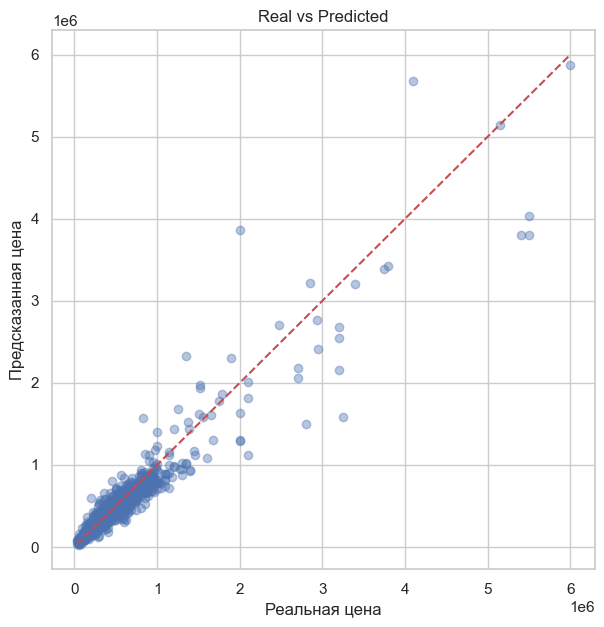

In [111]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test_real, pred_price, alpha=0.4)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         'r--')
plt.xlabel("Реальная цена")
plt.ylabel("Предсказанная цена")
plt.title("Real vs Predicted")
plt.grid(True)
plt.show()

> ### Почти идеальное предсказание, шумы и выбросы все-таки мешают, но в целом очень хорошо получилось!

# **<font color="green">Часть 5 | Создание интерактивного приложения на Streamlit (3 балла)</font>**

Вам необходимо создать интерактивное приложение на Streamlit, которое будет:

- Показывать основные информативные графики/гистограммы в рамках EDA (1 балл)
- На вход запрашивать csv-файл с признаками объектов или запрашивать признаки объекта в окошках для ввода, и применять на поступивших объектах модель (1 балл)
- Визуализировать веса обученной модели (1 балл)

# **Часть 6 | Оформление репозитория и оценка сервиса (3 балла)**

**Результаты вашей работы** необходимо разместить в своём GitHub-репозитории. В этот же репозиторий позже будет добавлена вторая часть.

Под результатами первой части понимаем следующее:

---

### Обязательные файлы:

1. **`.ipynb`-ноутбук** со всеми экспериментами:

   * полный EDA,
   * все шаги препроцессинга,
   * обучение и сравнение моделей,
   * сохранённые output’ы.

2. **`.pickle`-файл**, содержащий:

   * обученную модель (или пайплайн `scaler + model`);
   * параметры скейлинга;
   * любые числовые объекты, необходимые для инференса внутри Streamlit-приложения.

3. **`.md`-файл с выводами** о проделанной работе:

   * что было сделано (краткое описание каждого этапа);
   * какие результаты были получены (метрики + интерпретация);
   * что дало наибольший прирост качества;
   * что сделать не удалось и почему (это нормально и даже полезно);
   * **оценка разработанного сервиса**:

     * насколько приложение удобно в использовании;
     * что получилось визуализировать хорошо, а что — менее удачно;
     * какие ограничения или проблемы вы заметили;
     * какие улучшения планируете в следующей итерации.

По результатам второй части, ждем:

4. **Streamlit-приложение** (например, `app.py`), которое можно запустить командой:

   ```bash
   streamlit run app.py
   ```

**И ссылку на приложение в StreamlitHub.**

В приложении должно быть:

* отображение ключевых графиков EDA;
* ввод данных (CSV или ручной ввод);
* применение модели;
* визуализация весов/коэффициентов.



### **За что могут быть сняты баллы:**

* отсутствие `.pickle` с моделью / пайплайном;
* слабая или неполная аналитика в `.md`-файле;
* беспорядок в ноутбуке или неясная логика вычислений;
* отсутствие возможности запустить Streamlit-приложение.

In [109]:
models_dir = Path('../../HW1/models')
data_dir = Path('../../HW1/data')
os.makedirs(models_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

bundle_filename = 'best_model_bundle.pkl'
csv_train_filename_after_OHE = 'cleaned_train_data_after_ohe.csv'
csv_train_filename_before_OHE = 'cleaned_train_before_ohe.csv'
csv_test_filename_before_OHE = 'cleaned_test_before_ohe.csv'
csv_test_filename_after_OHE = 'cleaned_test_data_after_ohe.csv'

bundle_path = os.path.join(models_dir, bundle_filename)
csv_train_path_before_OHE = os.path.join(data_dir, csv_train_filename_before_OHE)
csv_train_path_after_OHE = os.path.join(data_dir, csv_train_filename_after_OHE)
csv_test_path_before_OHE = os.path.join(data_dir, csv_test_filename_before_OHE)
csv_test_path_after_OHE = os.path.join(data_dir, csv_test_filename_after_OHE)

print(f"Директории проверены/созданы: '{models_dir}', '{data_dir}'")
print("-" * 60)

bundle = {
    "model": best_ridge,
    "scaler": scaler,
    "columns_after_ohe": columns_after_ohe
}

print(f"Сохраняем бандл модели...")
with open(bundle_path, 'wb') as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Сохраняем обработанные данные...")
X_train_after_OHE.to_csv(csv_train_path_after_OHE, index=False)
X_train_before_OHE.to_csv(csv_train_path_before_OHE, index=False)
X_test_encoded_after_OHE.to_csv(csv_test_path_after_OHE, index=False)
X_test_before_OHE.to_csv(csv_test_path_before_OHE, index=False)

print("-" * 60)
print("ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ:")
print(f"1. [MODEL] {bundle_path:<40} | {os.path.getsize(bundle_path) / 1024:.2f} KB")
print(
    f"2. [DATA_TRAIN_AFTER_OHE]  {csv_train_path_after_OHE:<40} | {os.path.getsize(csv_train_path_after_OHE) / 1024:.2f} KB")
print(
    f"3. [DATA_TRAIN_BEFORE_OHE]  {csv_train_path_before_OHE:<40} | {os.path.getsize(csv_train_path_before_OHE) / 1024:.2f} KB")
print("-" * 60)
print(
    f"2. [DATA_TEST_AFTER_OHE]  {csv_test_path_after_OHE:<40} | {os.path.getsize(csv_test_path_after_OHE) / 1024:.2f} KB")
print(
    f"3. [DATA_TEST_BEFORE_OHE]  {csv_test_path_before_OHE:<40} | {os.path.getsize(csv_test_path_before_OHE) / 1024:.2f} KB")
print("-" * 60)

Директории проверены/созданы: '..\..\HW1\models', '..\..\HW1\data'
------------------------------------------------------------
Сохраняем бандл модели...
Сохраняем обработанные данные...
------------------------------------------------------------
ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ:
1. [MODEL] ..\..\HW1\models\best_model_bundle.pkl   | 3.18 KB
2. [DATA_TRAIN_AFTER_OHE]  ..\..\HW1\data\cleaned_train_data_after_ohe.csv | 1646.85 KB
3. [DATA_TRAIN_BEFORE_OHE]  ..\..\HW1\data\cleaned_train_before_ohe.csv | 766.28 KB
------------------------------------------------------------
2. [DATA_TEST_AFTER_OHE]  ..\..\HW1\data\cleaned_test_data_after_ohe.csv | 237.42 KB
3. [DATA_TEST_BEFORE_OHE]  ..\..\HW1\data\cleaned_test_before_ohe.csv | 122.07 KB
------------------------------------------------------------
